In [1]:
def confusion_matrix_article(Y,Z):
    print(type(Y),type(Z))
    
    
    np.seterr(divide='ignore', invalid='ignore')
    #print(np.diag(Y[0]))
    #print(sum(Z[0]))
    M = np.zeros((Y.shape[1],Y.shape[1]))
    W = np.zeros(Y.shape[1])
    print("M is ", M.shape)
    for i in range(len(Y)):
        if(np.allclose(Y[i],Z[i])):
            print(i, " - Y and Z are equal")
            C = np.diag(Y[i])
            print(C.shape)
        else:
            Y_complement_Z = np.where((Y[i]-Z[i])<0, 0, (Y[i]-Z[i]))
            print("|Yi\Zi| = ",sum(Y_complement_Z), ", shape = ", Y_complement_Z.shape)
            Z_complement_Y = np.where((Z[1]-Y[1])<0, 0, (Z[1]-Y[1]))
            print("|Zi\Yi| = ", sum(Z_complement_Y), ", shape = ", Y_complement_Z.shape)
            #Y_intersect_Z = (Y[i] & Z[i])
            
            for j in range(Y.shape[1]):
                if(Y[i][j]==Z[i][j]):
                    W[j]=Y[i][j]
                else:
                    W[j]=0
            
            Y_intersect_Z = W
            #### it will be a 861 x 861 matrix
            if (sum(Y_complement_Z)==0):  #if |Yi\Zi|=0
                # 𝐶=[(𝑌i∩𝑍i)⊗(𝑍i\𝑌i)+|𝑌i|⋅𝑑𝑖𝑎𝑔(𝑌i)]/|𝑍i|
                C1 = np.kron(Y_intersect_Z,Z_complement_Y)
                C2 = np.dot(sum(Y[i]),np.diag(Y[i]))
                C1 = C1.reshape(Y.shape[1],Y.shape[1]) 
                C = (C1+C2)/sum(Z[i])
            elif (sum(Z_complement_Y)==0):
                print("i = ", i)
                print("condiçao |Zi\Yi| =  0")
                print("kron:", np.kron(Y_complement_Z,Z[i]))
                C1 = np.kron(Y_complement_Z,Z[i])/sum(Z[i])
                if (np.isnan(np.min(C1))):
                    print("Tem nan em C1")
                    C1[np.isnan(C1)] = 0
                print("C1 = ", C1)
                C2 = np.diag(Z[i])
                if (np.isnan(np.min(C2))):
                    print("Tem nan em C1")
                    C2[np.isnan(C2)] = 0
                C1 = C1.reshape(Y.shape[1],Y.shape[1])
                C = C1+C2
            else:
                print("condiçao |Zi\Yi| diferente de 0")
                C1 = np.kron(Y_complement_Z,Z_complement_Y)/sum(Z_complement_Y)
                C2 = np.diag(Y_intersect_Z)
                C1 = C1.reshape(Y.shape[1],Y.shape[1])
                C = C1+C2
            print(C)
            M = M + C
    print("M = ", M)
    return M

In [2]:
def precision_matrix(M):
    #print(M.shape[0])
    rows = M.shape[0]
    columns = M.shape[1]
    sum_column = M.sum(axis=0)
    sum_row = M.sum(axis=1)
    precision_M = np.zeros((columns,rows))
    
    for i in range(columns):
        for j in range(rows):
            #print("sum_column[",i,"] = ",sum_column[i])
            #print("M[",j,"][",i,"] = ", M[j][i] )
            precision_M[j][i]= (M[j][i])/(sum_column[i])
            #print("precision_M[",j,"][",i,"] = ", precision_M[j][i] )
    
    if (np.isnan(np.min(precision_M))):
                    precision_M[np.isnan(precision_M)] = 0
    
    print("precision_M = ", precision_M)
    
    return precision_M

In [3]:
#!pip install scikit-multilearn -q

# para algoritmos adaptados usaremos KNN e Hierarquical ARAM NN
from skmultilearn.adapt import MLkNN, MLARAM
# para transformação de problemas usaremos Binary Relevance, Classifier Chain e Label Powerset
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss
import pandas as pd
import numpy as np
import sys
#np.set_printoptions(threshold=sys.maxsize)
from sklearn.naive_bayes import GaussianNB,MultinomialNB

## Load Train and Validation Dataframe (already one-hot encoded)

In [4]:
split_factor_file_train = "70_30"
split_factor_file_validation = "70_30"



df_train= pd.read_csv('/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Prepared_Data_for_ML_Input/PreparedData_train_Age_BMI_'+ split_factor_file_train + '.csv', sep=",")

df_validation = pd.read_csv('/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Prepared_Data_for_ML_Input/PreparedData_validation_Age_BMI_' + split_factor_file_validation + '.csv', sep=",")

In [5]:
df_train = df_train.drop(['Unnamed: 0','index'], axis=1)
print(df_train.shape)
df_train.head()


(1461, 792)


CTSF  CRHBP  WIF1  EGFL7  CLPS  GGT1  CEACAM1  EFEMP1  CCL17  ABL1  ...  \
0     0      0     0      0     0     0        0       0      0     0  ...   
1     0      0     0      0     0     0        0       0      0     0  ...   
2     0      0     0      0     0     0        0       0      0     0  ...   
3     0      0     0      0     0     0        0       0      0     0  ...   
4     0      0     0      0     0     0        0       0      0     0  ...   

   CXCL16  CLEC14A  IL10RB  CCL8  PVALB  RARRES1  AGRP  REG3A  Age  BMI  
0       0        0       0     0      0        0     0      1    1    3  
1       0        0       0     0      0        0     0      0    1    4  
2       0        0       0     0      0        0     0      0    1    4  
3       0        0       0     0      0        0     0      0    1    4  
4       0        0       0     0      0        0     0      0    1    4  

[5 rows x 792 columns]

In [6]:
if (split_factor_file_train != "60_40"):
    df_validation = df_validation.drop(['Unnamed: 0'], axis=1)
else:
    df_validation = df_validation.drop(['Unnamed: 0','index'], axis=1) #60_40 

print(df_validation.shape)
df_validation.head()

(211, 792)


CTSF  CRHBP  WIF1  EGFL7  CLPS  GGT1  CEACAM1  EFEMP1  CCL17  ABL1  ...  \
0     0      0     0      0     0     0        0       0      0     0  ...   
1     0      0     0      0     0     0        0       0      0     0  ...   
2     0      0     0      0     0     0        0       0      0     0  ...   
3     0      0     0      0     0     0        0       0      0     0  ...   
4     0      0     0      0     0     0        0       0      0     0  ...   

   IFNL1  MIA  MMP13  PADI2  PDCD1  TNFRSF11A  TNFRSF4  VTCN1  Age  BMI  
0      0    0      0      0      0          0        0      1    2    3  
1      1    0      0      0      0          0        0      0    2    3  
2      0    0      0      1      0          0        0      0    2    3  
3      0    0      0      0      0          0        0      0    2    3  
4      0    0      0      0      0          0        0      0    2    3  

[5 rows x 792 columns]

### Importante que <i>df_validation</i> tenha as mesmas colunas de <i>df_train</i>

In [7]:
print(df_train.dtypes)
print(df_validation.dtypes)

CTSF       int64
CRHBP      int64
WIF1       int64
EGFL7      int64
CLPS       int64
           ...  
RARRES1    int64
AGRP       int64
REG3A      int64
Age        int64
BMI        int64
Length: 792, dtype: object
CTSF         int64
CRHBP        int64
WIF1         int64
EGFL7        int64
CLPS         int64
             ...  
TNFRSF11A    int64
TNFRSF4      int64
VTCN1        int64
Age          int64
BMI          int64
Length: 792, dtype: object


## Treinamento

**Separação da classe e previsores**


In [8]:
df_train.iloc[:,-2:].values #generic features

array([[1, 3],
       [1, 4],
       [1, 4],
       ...,
       [5, 3],
       [5, 3],
       [5, 3]])

In [9]:
df_train.iloc[:,:-2].values #generic labels

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [10]:


classe = df_train.iloc[:,:-2].values #generic labels # df_train.iloc[:,:852].values #labels
previsores =  df_train.iloc[:,-2:].values #generic features     df_train.iloc[:,852:854].values #features
display(classe)


array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [11]:
classe.shape

(1461, 790)

In [12]:
display(previsores)

array([[1, 3],
       [1, 4],
       [1, 4],
       ...,
       [5, 3],
       [5, 3],
       [5, 3]])

In [13]:
previsores.shape

(1461, 2)

**Divisão de treino e teste**

- X_train will be the *previsores*
- y_train will be the *classes*

In [14]:
X_train = previsores
y_train = classe

In [15]:
X_train, y_train

(array([[1, 3],
        [1, 4],
        [1, 4],
        ...,
        [5, 3],
        [5, 3],
        [5, 3]]),
 array([[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [16]:
y_test = df_validation.iloc[:,:-2].values #labels
X_test = df_validation.iloc[:,-2:].values #features


#y_test = df_validation.iloc[:,:852].values #labels
#X_test = df_validation.iloc[:,852:854].values #features


### Table with scores from all models

In [17]:
df_model_scores = pd.DataFrame()
df_TP_CM = pd.DataFrame(columns = ['Model','Split','TP','Sorting'])
df_CPU_Time = pd.DataFrame()

## Algoritmo Adaptado

### KNN - Funciona OK
### Fix para scikit_Multilearn em https://github.com/scikit-multilearn/scikit-multilearn/issues/230

In [18]:
#http://scikit.ml/api/skmultilearn.adapt.mlknn.html
#from sklearn.model_selection import GridSearchCV
#parameters = {'k': range(1,int(classe.shape[1]/3)), 's': [0.5, 0.7, 1.0]}
#score = 'f1_macro'

#knn = GridSearchCV(MLkNN(), parameters, scoring=score)
#knn.fit(X_train, y_train) 

#print (knn.best_params_, knn.best_score_)

In [19]:
%%time
knn = MLkNN(k=int(classe.shape[1]/3)) 
knn.fit(X_train, y_train) 

CPU times: user 54.9 s, sys: 237 ms, total: 55.1 s
Wall time: 55.2 s


MLkNN(k=263)

**Previsão com dados de teste**



In [20]:
previsto = knn.predict(X_test) 

# atenção na saída e motivo de não ser visualizada
previsto.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [21]:
#y_test is already ndarray
Z = previsto.toarray()
print(Z.shape)
Y = y_test
print(Y.shape)
M = confusion_matrix_article(Y,Z)
precision_M = precision_matrix(M)

(211, 790)
(211, 790)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
M is  (790, 790)
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  0
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  1
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  2
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0

kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  40
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  41
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  42
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  80
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  81
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  82
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [

kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  122
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  123
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  124
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0

Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  163
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  164
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  165
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 

|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  205
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  206
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  207
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , sha

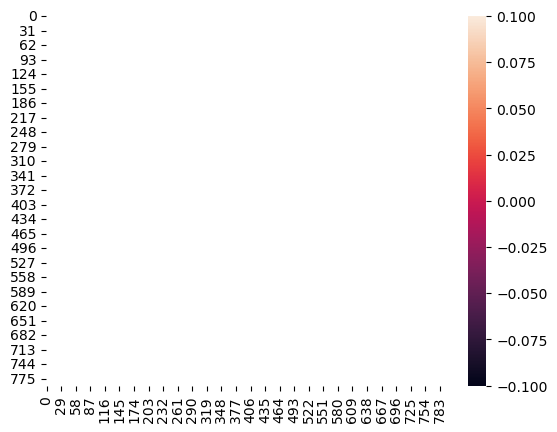

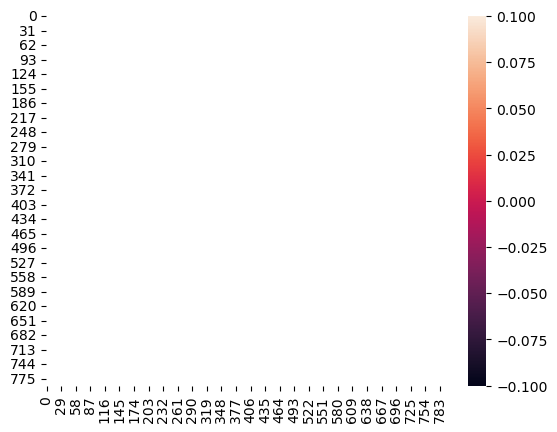

In [22]:
import seaborn as sns
import matplotlib.pylab as plt

ax = sns.heatmap(M, linewidth=0.5)
plt.show()

ax = sns.heatmap(precision_M, linewidth=0.5)
plt.show()

### Confusion Matrix Artigo

Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.

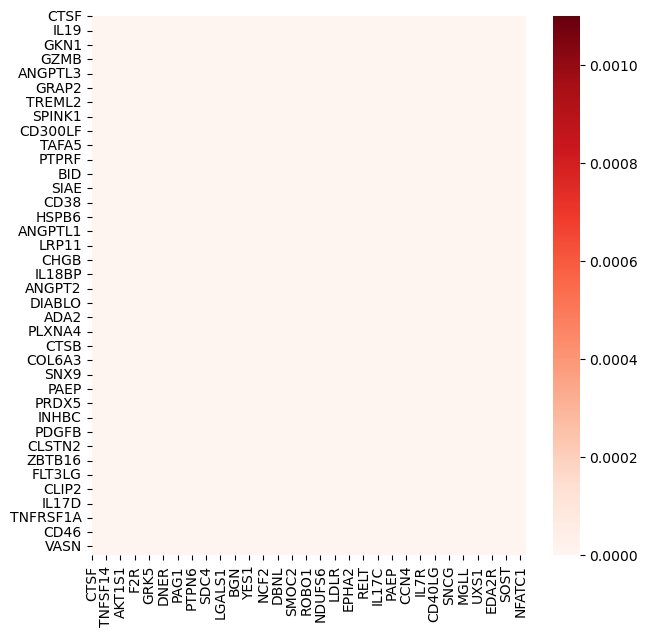

[]


<Figure size 640x480 with 0 Axes>

In [23]:
max_value = np.float64(0)
min_value = np.float64(0)


tp_indices_article = []


for row in range(0,len(precision_M)):
    #max_value = np.float64(max(precision_M[row,:]))
    
    
    #if(max(precision_M[row,:])>0):
    #    print(max(precision_M[row,:]>0))
    #else:
    #    print(max(precision_M[row,:]>0))
    if(max(precision_M[row,:])>0):
        tp_indices_article.append(row)
     
    if(max(precision_M[row,:])>max_value):
        if(max(precision_M[row,:])<1):
            max_value = np.float64(max(precision_M[row,:]))
            
    
    if(min(precision_M[row,:])>min_value):
        min_value = np.float64(min(precision_M[row,:]))
        
    print("Max value: ", max_value, ". Min value: ",min_value) 
    

if(max_value==0):
    max_value = np.float64(0.001)
    
    
plt.figure(figsize = (7,7))   
df_precision_M = pd.DataFrame(precision_M, columns = df_train.iloc[:,:-2].columns, index = df_train.iloc[:,:-2].columns )
df_precision_M
ax = sns.heatmap(df_precision_M,vmin=min_value, vmax=max_value*1.1, cmap="Reds")
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/MLKNN/CM_MLKNN_" + split_factor_file_train + "_article.eps", transparent=True, format='png')
plt.show()
plt.clf()


#rows que testaram true positive    
proteins_confusion_matrix_article = []
print(tp_indices_article)

if (len(tp_indices_article)>0):
    for i in tp_indices_article:
        proteins_confusion_matrix_article.append(df_train.columns[i])
        print(df_train.columns[i])
    proteins_confusion_matrix_article.append(max_value)
    pd.DataFrame(proteins_confusion_matrix_article).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/MLKNN/true_positive_proteins_Age_BMI_" + split_factor_file_train + ".csv") 



**Hamming para avaliar performance**


In [24]:
# equivalent to print(hamming_loss(y_test, previsto.toarray())) 
print(hamming_loss(y_test, previsto)) 

0.0012658227848101266


<class 'scipy.sparse._lil.lil_matrix'>
0.0
0.7329113924050633
0.0
0.0
[[[211   0]
  [  0   0]]

 [[210   0]
  [  1   0]]

 [[211   0]
  [  0   0]]

 ...

 [[210   0]
  [  1   0]]

 [[210   0]
  [  1   0]]

 [[210   0]
  [  1   0]]]
790
[]
[]


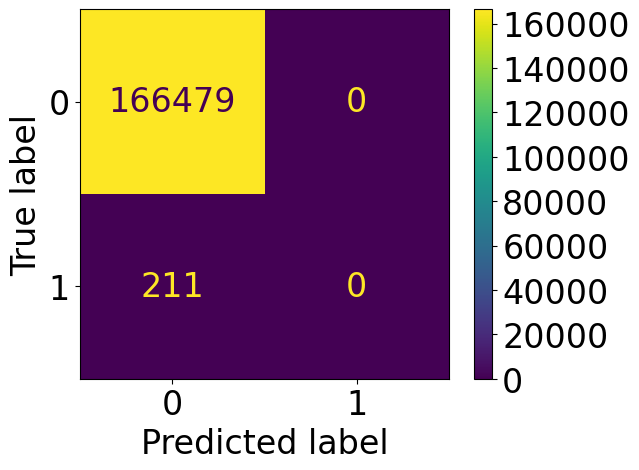

<Figure size 640x480 with 0 Axes>

In [25]:
# https://towardsdatascience.com/evaluating-multi-label-classifiers-a31be83da6ea 

from sklearn.metrics import multilabel_confusion_matrix
result = multilabel_confusion_matrix(y_test, previsto)[0]
result = multilabel_confusion_matrix(y_test, previsto)
result

print(type(previsto))

from sklearn.metrics import jaccard_score
print(jaccard_score(previsto,y_test, average='samples', zero_division=True))
print(jaccard_score(y_test,previsto, average='macro',zero_division=True))
print(jaccard_score(y_test,previsto, average='weighted',zero_division=True))
print(jaccard_score(y_test,previsto, average='micro',zero_division=True))

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
print(multilabel_confusion_matrix(y_test, previsto))


matrices = multilabel_confusion_matrix(y_test, previsto)

cm = confusion_matrix(y_test.ravel(), (previsto.A).ravel())

plt.rcParams.update({'font.size': 24})
# Create a ConfusionMatrixDisplay object
#cmd = ConfusionMatrixDisplay(cm, display_labels=[f"Class {i}" for i in range(2)])
cmd = ConfusionMatrixDisplay.from_predictions(y_test.ravel(), (previsto.A).ravel())
# Display the confusion matrix
cmd.plot()
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/MLKNN/CM_MLKNN_" + split_factor_file_train + "_flattened.eps", transparent=True, format='png',bbox_inches = 'tight')
plt.rcParams.update({'font.size': 10})
plt.clf()




num_classes = len(matrices)
print(num_classes)
# Initialize an empty list to store the true positive row indices
tp_indices = []

# Iterate over each class
for i in range(num_classes):
    # Get the confusion matrix for the current class
    class_cm = matrices[i]
    #print(class_cm.shape)
    
    # Extract the true positive count from the confusion matrix
    tp = class_cm[1, 1]
    
    # If the true positive count is greater than 0, add the index to the list
    if tp > 0:
        tp_indices.append(i)

        
#rows que testaram true positive        
print(tp_indices)
proteins_confusion_matrix_flattened = []
if (len(tp_indices)>0):
    for i in tp_indices:
        print(df_train.columns[i])
        proteins_confusion_matrix_flattened.append(df_train.columns[i])
    pd.DataFrame(proteins_confusion_matrix_flattened).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/MLKNN/true_positive_proteins__flattened_Age_BMI_" + split_factor_file_train + ".csv") 
        

true_positive_indices = np.where(matrices[:, 1, 1] == 1)[0]
print(true_positive_indices)

row_to_append = pd.DataFrame([{'Model' : 'MLkNN', 'Split' : split_factor_file_train, 'TP' : cm[1,1], 'Sorting' : 'BMI (given Age)'}])
df_TP_CM = pd.concat([df_TP_CM,row_to_append])



In the above code, tn, fp, fn, and tp represent the values from the confusion matrix. The index of the predicted label is determined by comparing the values of tn and fp. If tn is greater than fp, it indicates the label is predicted as negative (index 0), otherwise, it is predicted as positive (index 1).

At the end of this process, the predicted_labels list will contain the indexes of the predicted labels for each class. In the example given, predicted_labels will be [0, 1, 1], representing the predicted labels for each row.

Please note that the example provided assumes binary classification for each label. If you have more than two labels, you may need to modify the code accordingly.

- Para conseguir as proteinas, deve-se usar a formula de True Positives - aí pega-se a posição

### Precision, Recal, F-Score, Support

In [26]:
from sklearn.metrics import classification_report

labels = df_train.columns
len(labels)
label_names = labels[:-2]

print(classification_report(y_test, previsto,target_names=label_names,zero_division=1))
#print(classification_report(y_test, previsto,target_names=label_names,zero_division=1))

from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test, previsto, average='macro',zero_division=1))

#define rows to add
rows_to_append = pd.DataFrame([{'Model':'MLKNN', 'Proportion':split_factor_file_train, 
                                'HL':hamming_loss(y_test, previsto),
                               'Prec':precision_recall_fscore_support(y_test, previsto, average='macro',zero_division=1)[0],
                               'Rec':precision_recall_fscore_support(y_test, previsto, average='macro',zero_division=1)[1],
                               'F1':precision_recall_fscore_support(y_test, previsto, average='macro',zero_division=1)[2],
                               'Jac':jaccard_score(y_test,previsto, average='macro',zero_division=True)}])
                           

#add row to empty DataFrame
df_model_scores = pd.concat([df_model_scores, rows_to_append])
df_model_scores.head()

#df_model_scores = pd.DataFrame(columns = ["Model", "Proportion", "HL","Prec","Rec","F1","Jac"])

#print(precision_recall_fscore_support(y_test, previsto, average='micro',zero_division=1))

#print(precision_recall_fscore_support(y_test, previsto, average='weighted',zero_division=1))




                precision    recall  f1-score   support

          CTSF       1.00      1.00      1.00         0
         CRHBP       1.00      0.00      0.00         1
          WIF1       1.00      1.00      1.00         0
         EGFL7       1.00      0.00      0.00         1
          CLPS       1.00      1.00      1.00         0
          GGT1       1.00      0.00      0.00         1
       CEACAM1       1.00      0.00      0.00         1
        EFEMP1       1.00      1.00      1.00         0
         CCL17       1.00      1.00      1.00         0
          ABL1       1.00      1.00      1.00         0
        SPINK4       1.00      1.00      1.00         0
         NTRK3       1.00      1.00      1.00         0
      SERPINB6       1.00      1.00      1.00         0
          CFC1       1.00      1.00      1.00         0
         IGSF8       1.00      1.00      1.00         0
          NRP1       1.00      0.00      0.00         1
         STK11       1.00      1.00      1.00  

Model Proportion        HL  Prec       Rec        F1       Jac
0  MLKNN      70_30  0.001266   1.0  0.732911  0.732911  0.732911

### F1-Score
https://medium.com/analytics-vidhya/metrics-for-multi-label-classification-49cc5aeba1c3

In [27]:
from sklearn.metrics import f1_score

def f1_sampled(actual, pred):
    #converting the multi-label classification to a binary output
    #fitting the data for calculating the f1 score 
    f1 = f1_score(actual, pred, average = "macro",zero_division=1)
    return f1


print(f1_sampled(y_test, previsto))

0.7329113924050633


In [28]:
print(type(y_test), type(previsto))

<class 'numpy.ndarray'> <class 'scipy.sparse._lil.lil_matrix'>


### Hierarquical ARAM NN (Adaptive Resonance Associative Map Neural Network) - Funciona OK

In [29]:
%%time
aram = MLARAM()
aram.fit(X_train, y_train) 

CPU times: user 443 ms, sys: 102 ms, total: 545 ms
Wall time: 209 ms


MLARAM(neurons=[<skmultilearn.adapt.mlaram.Neuron object at 0x7f84e08e3be0>,
                <skmultilearn.adapt.mlaram.Neuron object at 0x7f84e08e23b0>,
                <skmultilearn.adapt.mlaram.Neuron object at 0x7f84e08e3ee0>,
                <skmultilearn.adapt.mlaram.Neuron object at 0x7f84e08e3df0>,
                <skmultilearn.adapt.mlaram.Neuron object at 0x7f84e08e3fa0>,
                <skmultilearn.adapt.mlaram.Neuron object at 0x7f84e0...
                <skmultilearn.adapt.mlaram.Neuron object at 0x7f84e08fc7f0>,
                <skmultilearn.adapt.mlaram.Neuron object at 0x7f84e08fc580>,
                <skmultilearn.adapt.mlaram.Neuron object at 0x7f84e08fc550>,
                <skmultilearn.adapt.mlaram.Neuron object at 0x7f84e08fdf30>,
                <skmultilearn.adapt.mlaram.Neuron object at 0x7f84e08fe110>,
                <skmultilearn.adapt.mlaram.Neuron object at 0x7f84e08fe080>,
                <skmultilearn.adapt.mlaram.Neuron object at 0x7f84e08fc730>, ...])

**Previsão com dados de teste**

In [30]:
previsto = aram.predict(X_test) 
previsto

array([[1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [31]:
#y_test is already ndarray
#Z = previsto
#Y = y_test
#print(Y.shape, Z.shape)
#print(type(Y), type(Z))
#for z in Z:
#    print(z)

#confusion_matrix_article(Y,Z)


#y_test is already ndarray
Z = previsto
print(Z.shape)
Y = y_test
print(Y.shape)
M = confusion_matrix_article(Y,Z)
precision_M = precision_matrix(M)
type(precision_M)



(211, 790)
(211, 790)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
M is  (790, 790)
|Yi\Zi| =  0.0 , shape =  (790,)
|Zi\Yi| =  120.0 , shape =  (790,)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00833333 0.         0.         ... 0.         0.         0.01666667]]
|Yi\Zi| =  1.0 , shape =  (790,)
|Zi\Yi| =  120.0 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1.0 , shape =  (790,)
|Zi\Yi| =  120.0 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1.0 , shape =  (790,)
|Zi\Yi| =  120.0 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1.0 , shape =  (790,)
|Zi\Yi| =  120.0 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1.0 , shape =  (790,)
|Zi\Yi| =  120.0 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1.0 , shape =  (790,)
|Zi\Yi| =  120.0 , shape =  (790,)
condiçao

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1.0 , shape =  (790,)
|Zi\Yi| =  120.0 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1.0 , shape =  (790,)
|Zi\Yi| =  120.0 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1.0 , shape =  (790,)
|Zi\Yi| =  120.0 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1.0 , shape =  (790,)
|Zi\Yi| =  120.0 , shape =  (790,)
condiçao

precision_M =  [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.00473934 0.         0.         ... 0.         0.         0.00471698]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.00473934 0.         0.         ... 0.         0.         0.00471698]
 [0.00473934 0.         0.         ... 0.         0.         0.00471698]
 [0.00473934 0.         0.         ... 0.         0.         0.00943396]]


numpy.ndarray

### Confusion Matrix Article

Max value:  0.0 . Min value:  0.0
Max value:  0.004739336492891005 . Min value:  0.0
Max value:  0.004739336492891005 . Min value:  0.0
Max value:  0.004739336492891005 . Min value:  0.0
Max value:  0.004739336492891005 . Min value:  0.0
Max value:  0.004739336492891005 . Min value:  0.0
Max value:  0.004739336492891005 . Min value:  0.0
Max value:  0.004739336492891005 . Min value:  0.0
Max value:  0.004739336492891005 . Min value:  0.0
Max value:  0.004739336492891005 . Min value:  0.0
Max value:  0.004739336492891005 . Min value:  0.0
Max value:  0.004739336492891005 . Min value:  0.0
Max value:  0.004739336492891005 . Min value:  0.0
Max value:  0.004739336492891005 . Min value:  0.0
Max value:  0.004739336492891005 . Min value:  0.0
Max value:  0.004739336492891005 . Min value:  0.0
Max value:  0.004739336492891005 . Min value:  0.0
Max value:  0.004739336492891005 . Min value:  0.0
Max value:  0.004739336492891005 . Min value:  0.0
Max value:  0.004739336492891005 . Min value:  0

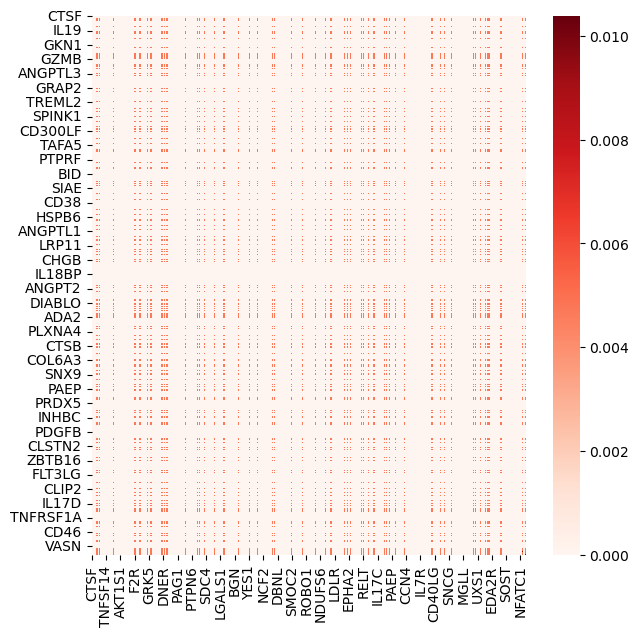

[1, 3, 5, 6, 15, 22, 24, 25, 32, 46, 54, 56, 57, 59, 60, 61, 62, 71, 72, 73, 74, 76, 84, 87, 105, 106, 110, 111, 124, 125, 135, 139, 147, 154, 161, 162, 164, 166, 169, 174, 179, 181, 186, 193, 195, 196, 197, 198, 209, 212, 214, 222, 223, 228, 242, 245, 248, 253, 260, 268, 269, 283, 284, 290, 298, 299, 300, 307, 312, 316, 319, 323, 327, 329, 334, 335, 338, 342, 345, 349, 356, 357, 359, 363, 366, 369, 373, 376, 391, 394, 397, 398, 403, 404, 415, 416, 417, 420, 421, 422, 425, 426, 428, 431, 432, 435, 437, 438, 440, 441, 451, 455, 457, 467, 468, 470, 474, 476, 479, 481, 484, 485, 494, 502, 503, 504, 508, 510, 512, 513, 517, 519, 523, 525, 527, 530, 532, 540, 542, 543, 546, 547, 548, 549, 559, 560, 562, 578, 581, 586, 588, 595, 597, 598, 599, 605, 615, 619, 620, 624, 625, 627, 632, 635, 643, 647, 651, 653, 659, 665, 666, 669, 675, 683, 687, 692, 697, 698, 700, 702, 709, 710, 714, 717, 721, 723, 724, 726, 740, 741, 742, 743, 748, 757, 758, 761, 763, 768, 769, 770, 779, 780, 781, 782, 783, 78

<Figure size 640x480 with 0 Axes>

In [32]:
max_value = np.float64(0)
min_value = np.float64(0)


tp_indices_article = []


for row in range(0,len(precision_M)):
    #max_value = np.float64(max(precision_M[row,:]))
    
    
    #if(max(precision_M[row,:])>0):
    #    print(max(precision_M[row,:]>0))
    #else:
    #    print(max(precision_M[row,:]>0))
    if(max(precision_M[row,:])>0):
        tp_indices_article.append(row)
     
    if(max(precision_M[row,:])>max_value):
        if(max(precision_M[row,:])<1):
            max_value = np.float64(max(precision_M[row,:]))
            
    
    if(min(precision_M[row,:])>min_value):
        min_value = np.float64(min(precision_M[row,:]))
        
    print("Max value: ", max_value, ". Min value: ",min_value) 
    

if(max_value==0):
    max_value = np.float64(0.001)
    
    
plt.figure(figsize = (7,7))   
df_precision_M = pd.DataFrame(precision_M, columns = df_train.iloc[:,:-2].columns, index = df_train.iloc[:,:-2].columns )
df_precision_M
ax = sns.heatmap(df_precision_M,vmin=min_value, vmax=max_value*1.1, cmap="Reds")
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/HARAM/CM_HARAM_" + split_factor_file_train + "_article.eps", transparent=True, format='png')

plt.show()
plt.clf()

#rows que testaram true positive    
proteins_confusion_matrix_article = []
print(tp_indices_article)
if (len(tp_indices_article)>0):
    for i in tp_indices_article:
        proteins_confusion_matrix_article.append(df_train.columns[i])
        print(df_train.columns[i])
    proteins_confusion_matrix_article.append(max_value)
    pd.DataFrame(proteins_confusion_matrix_article).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/HARAM/true_positive_proteins_Age_BMI_" + split_factor_file_train + ".csv") 
  

**Hamming para avaliar preformance**


In [33]:
print(hamming_loss(y_test, previsto)) 

0.011980322754814325


In [34]:
from sklearn.metrics import classification_report

labels = df_train.columns
len(labels)
label_names = labels[:-2]

print(classification_report(y_test, previsto,target_names=label_names,zero_division=1))
#print(classification_report(y_test, previsto,target_names=label_names,zero_division=1))

from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test, previsto, average='macro',zero_division=1))


#print(precision_recall_fscore_support(y_test, previsto, average='micro',zero_division=1))

#print(precision_recall_fscore_support(y_test, previsto, average='weighted',zero_division=1))




                precision    recall  f1-score   support

          CTSF       0.00      1.00      0.00         0
         CRHBP       1.00      0.00      0.00         1
          WIF1       1.00      1.00      1.00         0
         EGFL7       1.00      0.00      0.00         1
          CLPS       0.00      1.00      0.00         0
          GGT1       0.00      0.00      0.00         1
       CEACAM1       1.00      0.00      0.00         1
        EFEMP1       1.00      1.00      1.00         0
         CCL17       0.00      1.00      0.00         0
          ABL1       1.00      1.00      1.00         0
        SPINK4       0.00      1.00      0.00         0
         NTRK3       0.00      1.00      0.00         0
      SERPINB6       1.00      1.00      1.00         0
          CFC1       0.00      1.00      0.00         0
         IGSF8       0.00      1.00      0.00         0
          NRP1       0.00      0.00      0.00         1
         STK11       1.00      1.00      1.00  

In [35]:
from sklearn.metrics import f1_score

def f1_sampled(actual, pred):
    #converting the multi-label classification to a binary output
    #fitting the data for calculating the f1 score 
    f1 = f1_score(actual, pred, average = "macro",zero_division=1)
    return f1


print(f1_sampled(y_test, previsto))

0.43330087633885106


7.898894154818325e-05
0.43312236286919836
0.0007898894154818325
0.0010005002501250625
[[[200  11]
  [  0   0]]

 [[210   0]
  [  1   0]]

 [[211   0]
  [  0   0]]

 ...

 [[210   0]
  [  1   0]]

 [[210   0]
  [  1   0]]

 [[199  11]
  [  0   1]]]
<class 'numpy.ndarray'>
790
[784, 789]
IL10RB
REG3A
[784 789]


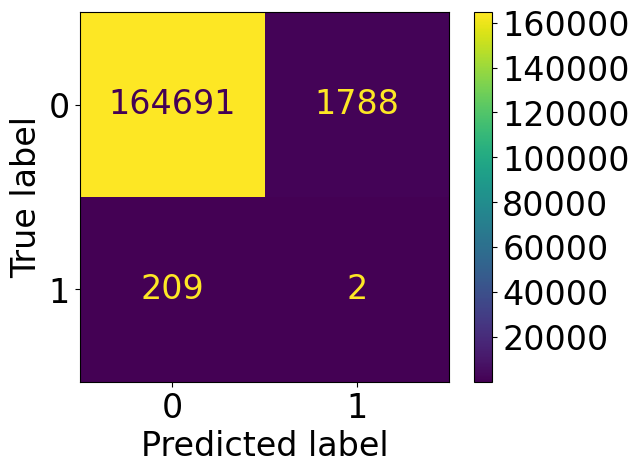

<Figure size 640x480 with 0 Axes>

In [36]:
from sklearn.metrics import jaccard_score
print(jaccard_score(previsto,y_test, average='samples', zero_division=True))
print(jaccard_score(y_test,previsto, average='macro',zero_division=True))
print(jaccard_score(y_test,previsto, average='weighted',zero_division=True))
print(jaccard_score(y_test,previsto, average='micro',zero_division=True))

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
print(multilabel_confusion_matrix(y_test, previsto))

print(type(previsto))

matrices = multilabel_confusion_matrix(y_test, previsto)

cm = confusion_matrix(y_test.ravel(), previsto.ravel())

plt.rcParams.update({'font.size': 24})
# Create a ConfusionMatrixDisplay object
#cmd = ConfusionMatrixDisplay(cm, display_labels=[f"Class {i}" for i in range(2)])
cmd = ConfusionMatrixDisplay.from_predictions(y_test.ravel(), previsto.ravel())
# Display the confusion matrix
cmd.plot()
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/HARAM/CM_HARAM_" + split_factor_file_train + "_flattened.eps", transparent=True, format='png',bbox_inches = 'tight')
plt.rcParams.update({'font.size': 10})
plt.clf()



num_classes = len(matrices)
print(num_classes)
# Initialize an empty list to store the true positive row indices
tp_indices = []

# Iterate over each class
for i in range(num_classes):
    # Get the confusion matrix for the current class
    class_cm = matrices[i]
    #print(class_cm.shape)
    
    # Extract the true positive count from the confusion matrix
    tp = class_cm[1, 1]
    
    # If the true positive count is greater than 0, add the index to the list
    if tp > 0:
        tp_indices.append(i)


#rows que testaram true positive        
print(tp_indices)
proteins_confusion_matrix_flattened = []
if (len(tp_indices)>0):
    for i in tp_indices:
        print(df_train.columns[i])
        proteins_confusion_matrix_flattened.append(df_train.columns[i])
    pd.DataFrame(proteins_confusion_matrix_flattened).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/HARAM/true_positive_proteins__flattened_Age_BMI_" + split_factor_file_train + ".csv") 
        
true_positive_indices = np.where(matrices[:, 1, 1] == 1)[0]
print(true_positive_indices)


#define rows to add
rows_to_append = pd.DataFrame([{'Model':'HARAM', 'Proportion':split_factor_file_train, 
                                'HL':hamming_loss(y_test, previsto),
                               'Prec':precision_recall_fscore_support(y_test, previsto, average='macro',zero_division=1)[0],
                               'Rec':precision_recall_fscore_support(y_test, previsto, average='macro',zero_division=1)[1],
                               'F1':precision_recall_fscore_support(y_test, previsto, average='macro',zero_division=1)[2],
                               'Jac':jaccard_score(y_test,previsto, average='macro',zero_division=True)}])
                           

#add row to empty DataFrame
df_model_scores = pd.concat([df_model_scores, rows_to_append])
df_model_scores.head()


row_to_append = pd.DataFrame([{'Model' : 'HARAM', 'Split' : split_factor_file_train, 'TP' : cm[1,1], 'Sorting' : 'BMI (given Age)'}])
df_TP_CM = pd.concat([df_TP_CM,row_to_append])

## Transformação de Problema

## Binary Relevance com Multinomial Naive Bayes

In [37]:
binary = BinaryRelevance(MultinomialNB())

#binary = BinaryRelevance(classifier = SVC())


In [38]:

%%time
binary.fit(X_train, y_train)
# https://stackoverflow.com/questions/67307405/how-to-resolve-valueerror-the-number-of-classes-has-to-be-greater-than-one-got 

CPU times: user 1.19 s, sys: 268 ms, total: 1.46 s
Wall time: 533 ms


BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])

In [39]:
previsao = binary.predict(X_test)
print(hamming_loss(y_test, previsao))

0.0012658227848101266


In [40]:
previsao.A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [41]:
from sklearn.metrics import classification_report

labels = df_train.columns
len(labels)
label_names = labels[:-2]

print(classification_report(y_test, previsao,target_names=label_names,zero_division=1))
#print(classification_report(y_test, previsto,target_names=label_names,zero_division=1))

from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test, previsao, average='macro',zero_division=1))


#print(precision_recall_fscore_support(y_test, previsto, average='micro',zero_division=1))

#print(precision_recall_fscore_support(y_test, previsto, average='weighted',zero_division=1))




                precision    recall  f1-score   support

          CTSF       1.00      1.00      1.00         0
         CRHBP       1.00      0.00      0.00         1
          WIF1       1.00      1.00      1.00         0
         EGFL7       1.00      0.00      0.00         1
          CLPS       1.00      1.00      1.00         0
          GGT1       1.00      0.00      0.00         1
       CEACAM1       1.00      0.00      0.00         1
        EFEMP1       1.00      1.00      1.00         0
         CCL17       1.00      1.00      1.00         0
          ABL1       1.00      1.00      1.00         0
        SPINK4       1.00      1.00      1.00         0
         NTRK3       1.00      1.00      1.00         0
      SERPINB6       1.00      1.00      1.00         0
          CFC1       1.00      1.00      1.00         0
         IGSF8       1.00      1.00      1.00         0
          NRP1       1.00      0.00      0.00         1
         STK11       1.00      1.00      1.00  

In [42]:
from sklearn.metrics import f1_score

def f1_sampled(actual, pred):
    #converting the multi-label classification to a binary output
    #fitting the data for calculating the f1 score 
    f1 = f1_score(actual, pred, average = "macro",zero_division=1)
    return f1


print(f1_sampled(y_test, previsto))

0.43330087633885106


0.0
0.7329113924050633
0.0
0.0
[[[211   0]
  [  0   0]]

 [[210   0]
  [  1   0]]

 [[211   0]
  [  0   0]]

 ...

 [[210   0]
  [  1   0]]

 [[210   0]
  [  1   0]]

 [[210   0]
  [  1   0]]]
790
[]
[]


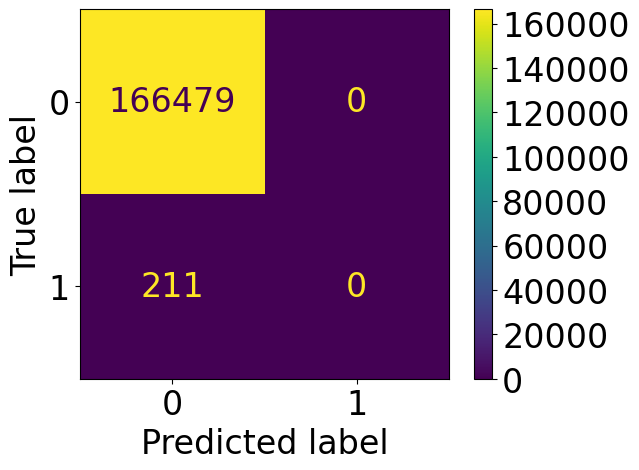

<Figure size 640x480 with 0 Axes>

In [43]:
from sklearn.metrics import jaccard_score
print(jaccard_score(previsao.A,y_test, average='samples', zero_division=True))
print(jaccard_score(y_test,previsao.A, average='macro',zero_division=True))
print(jaccard_score(y_test,previsao.A, average='weighted',zero_division=True))
print(jaccard_score(y_test,previsao.A, average='micro',zero_division=True))

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
print(multilabel_confusion_matrix(y_test, previsao))


matrices = multilabel_confusion_matrix(y_test, previsao.A)

cm = confusion_matrix(y_test.ravel(), previsao.A.ravel())

plt.rcParams.update({'font.size': 24})
# Create a ConfusionMatrixDisplay object
#cmd = ConfusionMatrixDisplay(cm, display_labels=[f"Class {i}" for i in range(2)])
cmd = ConfusionMatrixDisplay.from_predictions(y_test.ravel(), previsao.A.ravel(),values_format='')
# Display the confusion matrix
cmd.plot()
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/BR_MultinomialNB/CM_BR_MultinomialNB_" + split_factor_file_train + "_flattened.eps", transparent=True, format='png',bbox_inches = 'tight')
plt.rcParams.update({'font.size': 10})
plt.clf()


num_classes = len(matrices)
print(num_classes)
# Initialize an empty list to store the true positive row indices
tp_indices = []

# Iterate over each class
for i in range(num_classes):
    # Get the confusion matrix for the current class
    class_cm = matrices[i]
    #print(class_cm.shape)
    
    # Extract the true positive count from the confusion matrix
    tp = class_cm[1, 1]
    
    # If the true positive count is greater than 0, add the index to the list
    if tp > 0:
        tp_indices.append(i)


#rows que testaram true positive        
print(tp_indices)
proteins_confusion_matrix_flattened = []
if (len(tp_indices)>0):
    for i in tp_indices:
        print(df_train.columns[i])
        proteins_confusion_matrix_flattened.append(df_train.columns[i])
    pd.DataFrame(proteins_confusion_matrix_flattened).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/BR_MultinomialNB/true_positive_proteins__flattened_Age_BMI_" + split_factor_file_train + ".csv") 
 


true_positive_indices = np.where(matrices[:, 1, 1] == 1)[0]
print(true_positive_indices)


#define rows to add
rows_to_append = pd.DataFrame([{'Model':'BR_MultinomialNB', 'Proportion':split_factor_file_train, 
                                'HL':hamming_loss(y_test, previsao),
                               'Prec':precision_recall_fscore_support(y_test, previsao, average='macro',zero_division=1)[0],
                               'Rec':precision_recall_fscore_support(y_test, previsao, average='macro',zero_division=1)[1],
                               'F1':precision_recall_fscore_support(y_test, previsao, average='macro',zero_division=1)[2],
                               'Jac':jaccard_score(y_test,previsao, average='macro',zero_division=True)}])
                           

df_model_scores = pd.concat([df_model_scores, rows_to_append])
df_model_scores.head()

row_to_append = pd.DataFrame([{'Model' : 'BRV NB', 'Split' : split_factor_file_train, 'TP' : cm[1,1], 'Sorting' : 'BMI (given Age)'}])
df_TP_CM = pd.concat([df_TP_CM,row_to_append])

(211, 790)
(211, 790)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
M is  (790, 790)
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  0
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  1
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  2
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0

Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  33
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  34
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  35
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 

|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  68
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  69
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  70
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  104
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  105
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  106
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]

kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  141
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  142
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  143
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  177
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  178
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  179
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]

precision_M =  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


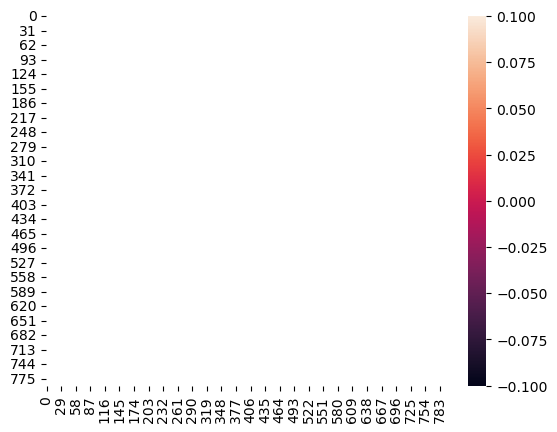

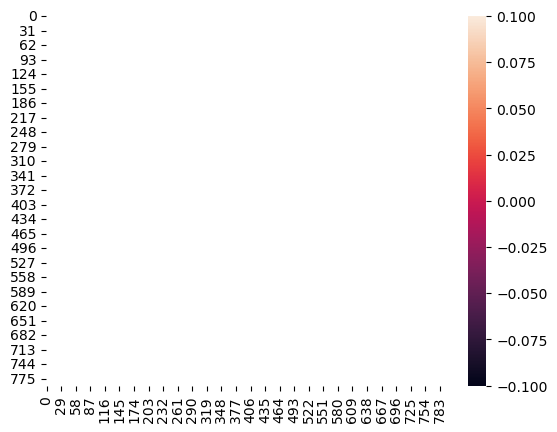

In [44]:
#y_test is already ndarray
Z = previsao.A
print(Z.shape)
Y = y_test
print(Y.shape)
M = confusion_matrix_article(Y,Z)
precision_M = precision_matrix(M)

ax = sns.heatmap(M, linewidth=0.5)
plt.show()

ax = sns.heatmap(precision_M, linewidth=0.5)
plt.show()

### Confusion matrix Article

Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.

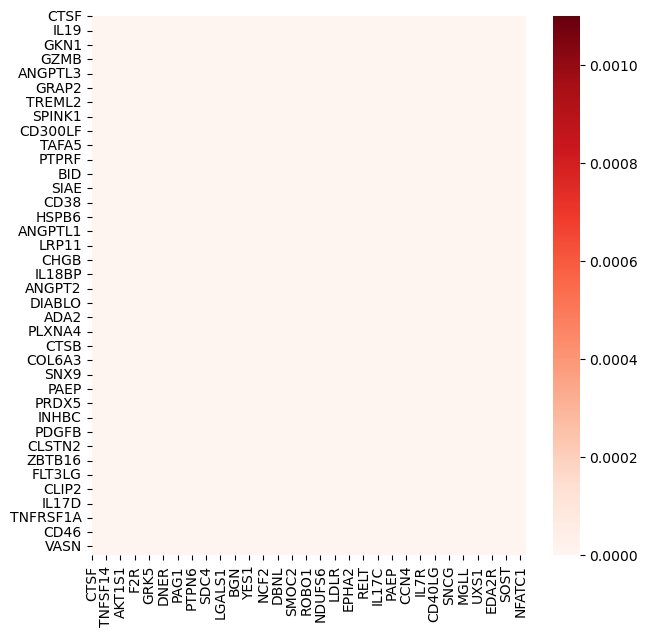

[]


<Figure size 640x480 with 0 Axes>

In [45]:
max_value = np.float64(0)
min_value = np.float64(0)


tp_indices_article = []


for row in range(0,len(precision_M)):
    #max_value = np.float64(max(precision_M[row,:]))
    
    
    #if(max(precision_M[row,:])>0):
    #    print(max(precision_M[row,:]>0))
    #else:
    #    print(max(precision_M[row,:]>0))
    if(max(precision_M[row,:])>0):
        tp_indices_article.append(row)
     
    if(max(precision_M[row,:])>max_value):
        if(max(precision_M[row,:])<1):
            max_value = np.float64(max(precision_M[row,:]))
            
    
    if(min(precision_M[row,:])>min_value):
        min_value = np.float64(min(precision_M[row,:]))
        
    print("Max value: ", max_value, ". Min value: ",min_value) 
    

if(max_value==0):
    max_value = np.float64(0.001)
    
    
plt.figure(figsize = (7,7))   
df_precision_M = pd.DataFrame(precision_M, columns = df_train.iloc[:,:-2].columns, index = df_train.iloc[:,:-2].columns )
df_precision_M
ax = sns.heatmap(df_precision_M,vmin=min_value, vmax=max_value*1.1, cmap="Reds")
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/BR_MultinomialNB/CM_BR_MultinomialNB_" + split_factor_file_train + "_article.eps", transparent=True, format='png')

plt.show()
plt.clf()

#rows que testaram true positive    
proteins_confusion_matrix_article = []
print(tp_indices_article)
if (len(tp_indices_article)>0):
    for i in tp_indices_article:
        proteins_confusion_matrix_article.append(df_train.columns[i])
        print(df_train.columns[i])
    proteins_confusion_matrix_article.append(max_value)
    pd.DataFrame(proteins_confusion_matrix_article).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/BR_MultinomialNB/true_positive_proteins_Age_BMI_" + split_factor_file_train + ".csv") 

### Label Powerset with GradientBoostingClassifier

In [46]:
#binary = BinaryRelevance(GaussianNB()) #Agora com Gaussian NB

from sklearn.ensemble import GradientBoostingClassifier
#binary = BinaryRelevance(GaussianNB()) #Agora com Gaussian NB
#binary = BinaryRelevance(BernoulliNB())
#binary = BinaryRelevance(GradientBoostingClassifier())
binary = LabelPowerset(GradientBoostingClassifier())

In [47]:
%%time
binary.fit(X_train, y_train)

CPU times: user 7min 2s, sys: 2.71 s, total: 7min 4s
Wall time: 7min 5s


LabelPowerset(classifier=GradientBoostingClassifier(),
              require_dense=[True, True])

In [48]:
previsao = binary.predict(X_test)

In [49]:
print(hamming_loss(y_test, previsao))

0.002531645569620253


In [50]:
from sklearn.metrics import classification_report

labels = df_train.columns
len(labels)
label_names = labels[:-2]

print(classification_report(y_test, previsao,target_names=label_names,zero_division=1))
#print(classification_report(y_test, previsto,target_names=label_names,zero_division=1))

from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test, previsao, average='macro',zero_division=1))


#print(precision_recall_fscore_support(y_test, previsto, average='micro',zero_division=1))

#print(precision_recall_fscore_support(y_test, previsto, average='weighted',zero_division=1))




                precision    recall  f1-score   support

          CTSF       1.00      1.00      1.00         0
         CRHBP       1.00      0.00      0.00         1
          WIF1       1.00      1.00      1.00         0
         EGFL7       1.00      0.00      0.00         1
          CLPS       1.00      1.00      1.00         0
          GGT1       1.00      0.00      0.00         1
       CEACAM1       1.00      0.00      0.00         1
        EFEMP1       1.00      1.00      1.00         0
         CCL17       1.00      1.00      1.00         0
          ABL1       1.00      1.00      1.00         0
        SPINK4       1.00      1.00      1.00         0
         NTRK3       1.00      1.00      1.00         0
      SERPINB6       1.00      1.00      1.00         0
          CFC1       1.00      1.00      1.00         0
         IGSF8       1.00      1.00      1.00         0
          NRP1       1.00      0.00      0.00         1
         STK11       1.00      1.00      1.00  

In [51]:
from sklearn.metrics import f1_score

def f1_sampled(actual, pred):
    #converting the multi-label classification to a binary output
    #fitting the data for calculating the f1 score 
    f1 = f1_score(actual, pred, average = "macro",zero_division=1)
    return f1


print(f1_sampled(y_test, previsao))

0.7291139240506329


0.0
0.7291139240506329
0.0
0.0
[[[211   0]
  [  0   0]]

 [[210   0]
  [  1   0]]

 [[211   0]
  [  0   0]]

 ...

 [[210   0]
  [  1   0]]

 [[210   0]
  [  1   0]]

 [[210   0]
  [  1   0]]]
790
[]
[]


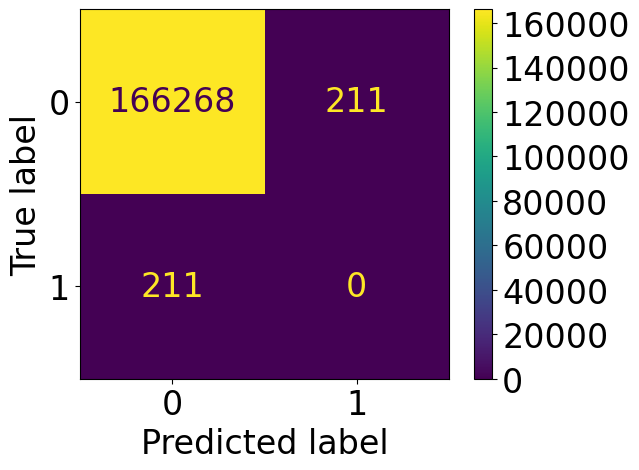

<Figure size 640x480 with 0 Axes>

In [52]:
from sklearn.metrics import jaccard_score
print(jaccard_score(previsao.A,y_test, average='samples', zero_division=True))
print(jaccard_score(y_test,previsao.A, average='macro',zero_division=True))
print(jaccard_score(y_test,previsao.A, average='weighted',zero_division=True))
print(jaccard_score(y_test,previsao.A, average='micro',zero_division=True))

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
print(multilabel_confusion_matrix(y_test, previsao))


matrices = multilabel_confusion_matrix(y_test, previsao.A)

cm = confusion_matrix(y_test.ravel(), previsao.A.ravel())

plt.rcParams.update({'font.size': 24})
# Create a ConfusionMatrixDisplay object
#cmd = ConfusionMatrixDisplay(cm, display_labels=[f"Class {i}" for i in range(2)])
cmd = ConfusionMatrixDisplay.from_predictions(y_test.ravel(), previsao.A.ravel(),values_format='')
# Display the confusion matrix
cmd.plot()
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/BR_GaussianNB/CM_BR_GaussianNB_" + split_factor_file_train + "_flattened.eps", transparent=True, format='png',bbox_inches = 'tight')
plt.rcParams.update({'font.size': 10})
plt.clf()


num_classes = len(matrices)
print(num_classes)
# Initialize an empty list to store the true positive row indices
tp_indices = []

# Iterate over each class
for i in range(num_classes):
    # Get the confusion matrix for the current class
    class_cm = matrices[i]
    #print(class_cm.shape)
    
    # Extract the true positive count from the confusion matrix
    tp = class_cm[1, 1]
    
    # If the true positive count is greater than 0, add the index to the list
    if tp > 0:
        tp_indices.append(i)


#rows que testaram true positive        
print(tp_indices)
proteins_confusion_matrix_flattened = []
if (len(tp_indices)>0):
    for i in tp_indices:
        print(df_train.columns[i])
        proteins_confusion_matrix_flattened.append(df_train.columns[i])
    pd.DataFrame(proteins_confusion_matrix_flattened).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/BR_GaussianNB/true_positive_proteins__flattened_Age_BMI_" + split_factor_file_train + ".csv") 
 
        
        
true_positive_indices = np.where(matrices[:, 1, 1] == 1)[0]
print(true_positive_indices)

#define rows to add
rows_to_append = pd.DataFrame([{'Model':'Label Powerset GradientBooster', 'Proportion':split_factor_file_train, 
                                'HL':hamming_loss(y_test, previsao),
                               'Prec':precision_recall_fscore_support(y_test, previsao, average='macro',zero_division=1)[0],
                               'Rec':precision_recall_fscore_support(y_test, previsao, average='macro',zero_division=1)[1],
                               'F1':precision_recall_fscore_support(y_test, previsao, average='macro',zero_division=1)[2],
                               'Jac':jaccard_score(y_test,previsao, average='macro',zero_division=True)}])
                           

#add row to empty DataFrame
df_model_scores = pd.concat([df_model_scores, rows_to_append])

df_model_scores.head()

row_to_append = pd.DataFrame([{'Model' : 'LPS GB', 'Split' : split_factor_file_train, 'TP' : cm[1,1], 'Sorting' : 'BMI (given Age)'}])
df_TP_CM = pd.concat([df_TP_CM,row_to_append])

(211, 790)
(211, 790)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
M is  (790, 790)
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0


precision_M =  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


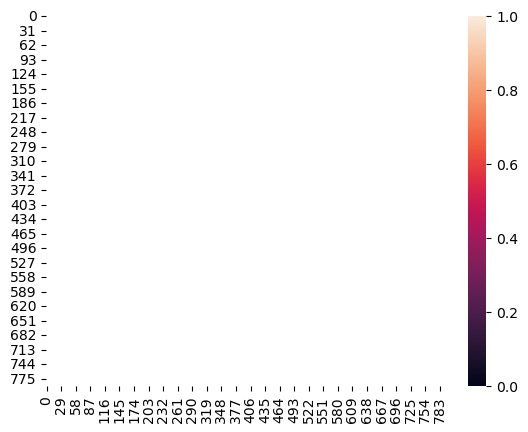

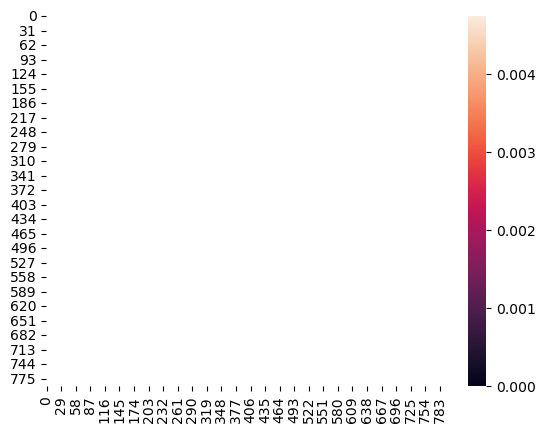

In [53]:
#y_test is already ndarray
Z = previsao.A
print(Z.shape)
Y = y_test
print(Y.shape)
M = confusion_matrix_article(Y,Z)
precision_M = precision_matrix(M)

ax = sns.heatmap(M, linewidth=0.5)
plt.show()

ax = sns.heatmap(precision_M, linewidth=0.5)
plt.show()

### Confusion Matrix Article

Max value:  0.0 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0

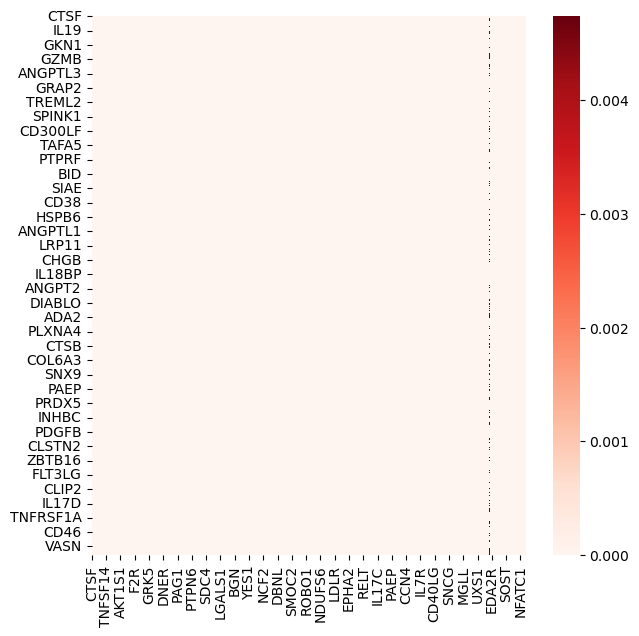

[1, 3, 5, 6, 15, 22, 24, 25, 32, 46, 54, 56, 57, 59, 60, 61, 62, 71, 72, 73, 74, 76, 84, 87, 105, 106, 110, 111, 124, 125, 135, 139, 147, 154, 161, 162, 164, 166, 169, 174, 179, 181, 186, 193, 195, 196, 197, 198, 209, 212, 214, 222, 223, 228, 242, 245, 248, 253, 260, 268, 269, 283, 284, 290, 298, 299, 300, 307, 312, 316, 319, 323, 327, 329, 334, 335, 338, 342, 345, 349, 356, 357, 359, 363, 366, 369, 373, 376, 391, 394, 397, 398, 403, 404, 415, 416, 417, 420, 421, 422, 425, 426, 428, 431, 432, 435, 437, 438, 440, 441, 451, 455, 457, 467, 468, 470, 474, 476, 479, 481, 484, 485, 494, 502, 503, 504, 508, 510, 512, 513, 517, 519, 523, 525, 527, 530, 532, 540, 542, 543, 546, 547, 548, 549, 559, 560, 562, 578, 581, 586, 588, 595, 597, 598, 599, 605, 615, 619, 620, 624, 625, 627, 632, 635, 643, 647, 651, 653, 659, 665, 666, 669, 675, 683, 687, 692, 697, 698, 700, 702, 709, 710, 714, 717, 721, 723, 724, 726, 740, 741, 742, 743, 748, 757, 758, 761, 763, 768, 769, 770, 779, 780, 781, 782, 783, 78

<Figure size 640x480 with 0 Axes>

In [54]:
max_value = np.float64(0)
min_value = np.float64(0)


tp_indices_article = []


for row in range(0,len(precision_M)):
    #max_value = np.float64(max(precision_M[row,:]))
    
    
    #if(max(precision_M[row,:])>0):
    #    print(max(precision_M[row,:]>0))
    #else:
    #    print(max(precision_M[row,:]>0))
    if(max(precision_M[row,:])>0):
        tp_indices_article.append(row)
     
    if(max(precision_M[row,:])>max_value):
        if(max(precision_M[row,:])<1):
            max_value = np.float64(max(precision_M[row,:]))
            
    
    if(min(precision_M[row,:])>min_value):
        min_value = np.float64(min(precision_M[row,:]))
        
    print("Max value: ", max_value, ". Min value: ",min_value) 
    

if(max_value==0):
    max_value = np.float64(0.001)
    
    
plt.figure(figsize = (7,7))   
df_precision_M = pd.DataFrame(precision_M, columns = df_train.iloc[:,:-2].columns, index = df_train.iloc[:,:-2].columns )
df_precision_M
ax = sns.heatmap(df_precision_M,vmin=min_value, vmax=max_value, cmap="Reds")
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/BR_GaussianNB/CM_BR_GaussianNB_" + split_factor_file_train + "_article.eps", transparent=True, format='png')
plt.show()
plt.clf()

#rows que testaram true positive    
proteins_confusion_matrix_article = []
print(tp_indices_article)
if (len(tp_indices_article)>0):
    for i in tp_indices_article:
        proteins_confusion_matrix_article.append(df_train.columns[i])
        print(df_train.columns[i])
    proteins_confusion_matrix_article.append(max_value)
    pd.DataFrame(proteins_confusion_matrix_article).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/BR_GaussianNB/true_positive_proteins_Age_BMI_" + split_factor_file_train + ".csv") 

### Classifier Chain

In [55]:
%%time

#chain = ClassifierChain(classifier = MultinomialNB())
#chain.fit(X_train, y_train)
#previsoes = chain.predict(X_test)
#print(hamming_loss(y_test,previsoes))
from sklearn.tree import ExtraTreeClassifier
chain = ClassifierChain(classifier = ExtraTreeClassifier())
chain.fit(X_train, y_train)
previsoes = chain.predict(X_test)
print(hamming_loss(y_test,previsoes))

0.0025196472493850862
CPU times: user 3.3 s, sys: 34.9 ms, total: 3.34 s
Wall time: 3.35 s


In [56]:
from sklearn.metrics import classification_report

labels = df_train.columns
len(labels)
label_names = labels[:-2]

print(classification_report(y_test, previsoes,target_names=label_names,zero_division=1))
#print(classification_report(y_test, previsto,target_names=label_names,zero_division=1))

from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test, previsoes, average='macro',zero_division=1))


#print(precision_recall_fscore_support(y_test, previsto, average='micro',zero_division=1))

#print(precision_recall_fscore_support(y_test, previsto, average='weighted',zero_division=1))




                precision    recall  f1-score   support

          CTSF       1.00      1.00      1.00         0
         CRHBP       1.00      0.00      0.00         1
          WIF1       1.00      1.00      1.00         0
         EGFL7       1.00      0.00      0.00         1
          CLPS       1.00      1.00      1.00         0
          GGT1       1.00      0.00      0.00         1
       CEACAM1       1.00      0.00      0.00         1
        EFEMP1       1.00      1.00      1.00         0
         CCL17       1.00      1.00      1.00         0
          ABL1       1.00      1.00      1.00         0
        SPINK4       1.00      1.00      1.00         0
         NTRK3       1.00      1.00      1.00         0
      SERPINB6       1.00      1.00      1.00         0
          CFC1       1.00      1.00      1.00         0
         IGSF8       1.00      1.00      1.00         0
          NRP1       1.00      0.00      0.00         1
         STK11       1.00      1.00      1.00  

In [57]:
from sklearn.metrics import f1_score

def f1_sampled(actual, pred):
    #converting the multi-label classification to a binary output
    #fitting the data for calculating the f1 score 
    f1 = f1_score(actual, pred, average = "macro",zero_division=1)
    return f1


print(f1_sampled(y_test, previsoes))

0.7316576827569499


0.004739336492890996
0.7316516553067185
2.278527160043748e-05
0.0023752969121140144
[[[211   0]
  [  0   0]]

 [[210   0]
  [  1   0]]

 [[211   0]
  [  0   0]]

 ...

 [[210   0]
  [  1   0]]

 [[210   0]
  [  1   0]]

 [[210   0]
  [  1   0]]]
790
[789]
REG3A
[789]


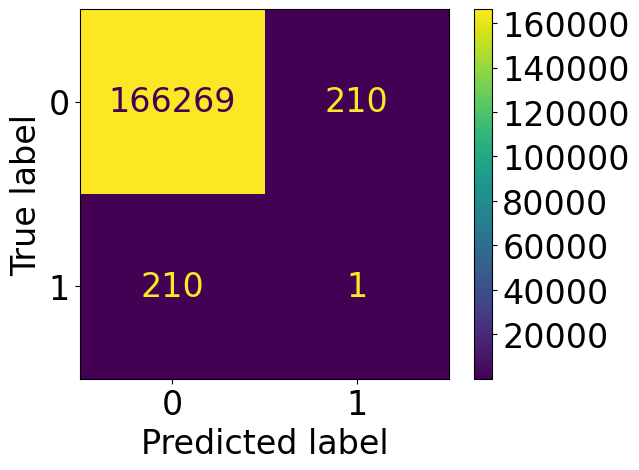

<Figure size 640x480 with 0 Axes>

In [58]:
from sklearn.metrics import jaccard_score
print(jaccard_score(previsoes.A,y_test, average='samples', zero_division=True))
print(jaccard_score(y_test,previsoes.A, average='macro',zero_division=True))
print(jaccard_score(y_test,previsoes.A, average='weighted',zero_division=True))
print(jaccard_score(y_test,previsoes.A, average='micro',zero_division=True))

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
print(multilabel_confusion_matrix(y_test, previsao))


matrices = multilabel_confusion_matrix(y_test, previsoes.A)

cm = confusion_matrix(y_test.ravel(), previsoes.A.ravel())


plt.rcParams.update({'font.size': 24})
# Create a ConfusionMatrixDisplay object
#cmd = ConfusionMatrixDisplay(cm, display_labels=[f"Class {i}" for i in range(2)])
cmd = ConfusionMatrixDisplay.from_predictions(y_test.ravel(), previsoes.A.ravel(),values_format='')
# Display the confusion matrix
cmd.plot()
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/ClassifierChains/CM_ClassifierChains_" + split_factor_file_train + "_flattened.eps", transparent=True, format='png', bbox_inches='tight')
plt.rcParams.update({'font.size': 10})
plt.clf()




num_classes = len(matrices)
print(num_classes)
# Initialize an empty list to store the true positive row indices
tp_indices = []

# Iterate over each class
for i in range(num_classes):
    # Get the confusion matrix for the current class
    class_cm = matrices[i]
    #print(class_cm.shape)
    
    # Extract the true positive count from the confusion matrix
    tp = class_cm[1, 1]
    
    # If the true positive count is greater than 0, add the index to the list
    if tp > 0:
        tp_indices.append(i)


#rows que testaram true positive        
print(tp_indices)
proteins_confusion_matrix_flattened = []
if (len(tp_indices)>0):
    for i in tp_indices:
        print(df_train.columns[i])
        proteins_confusion_matrix_flattened.append(df_train.columns[i])
    pd.DataFrame(proteins_confusion_matrix_flattened).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/ClassifierChains/true_positive_proteins__flattened_Age_BMI_" + split_factor_file_train + ".csv") 
 
true_positive_indices = np.where(matrices[:, 1, 1] == 1)[0]
print(true_positive_indices)


#define rows to add
rows_to_append = pd.DataFrame([{'Model':'ClassifierChain', 'Proportion':split_factor_file_train, 
                                'HL':hamming_loss(y_test, previsoes),
                               'Prec':precision_recall_fscore_support(y_test, previsoes, average='macro',zero_division=1)[0],
                               'Rec':precision_recall_fscore_support(y_test, previsoes, average='macro',zero_division=1)[1],
                               'F1':precision_recall_fscore_support(y_test, previsoes, average='macro',zero_division=1)[2],
                               'Jac':jaccard_score(y_test,previsoes, average='macro',zero_division=True)}])
                           

#add row to empty DataFrame
df_model_scores = pd.concat([df_model_scores, rows_to_append])

df_model_scores.head()


row_to_append = pd.DataFrame([{'Model' : 'CC', 'Split' : split_factor_file_train, 'TP' : cm[1,1], 'Sorting' : 'BMI (given Age)'}])
df_TP_CM = pd.concat([df_TP_CM,row_to_append])

In [59]:
#             Predicted
#             0       1
# Actual 0   TN      FP
#        1   FN      TP


- TN (True Negative): The number of correctly predicted negative instances.
- FP (False Positive): The number of incorrectly predicted positive instances.
- FN (False Negative): The number of incorrectly predicted negative instances.
- TP (True Positive): The number of correctly predicted positive instances.

(211, 790)
(211, 790)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
M is  (790, 790)
0  - Y and Z are equal
(790, 790)
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0


|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0


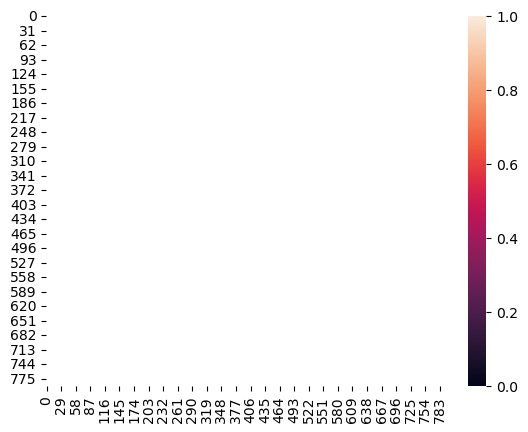

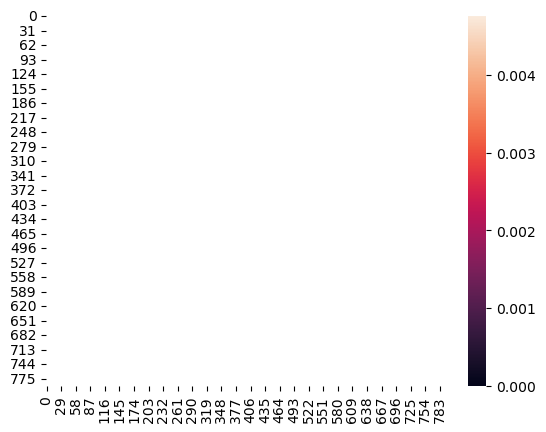

In [60]:
#y_test is already ndarray
Z = previsoes.A
print(Z.shape)
Y = y_test
print(Y.shape)
M = confusion_matrix_article(Y,Z)
precision_M = precision_matrix(M)

ax = sns.heatmap(M, linewidth=0.5)
plt.show()

ax = sns.heatmap(precision_M, linewidth=0.5)
plt.show()

### Confusion Matrix Article

Max value:  0.0 . Min value:  0.0
Max value:  0.004761904761904762 . Min value:  0.0
Max value:  0.004761904761904762 . Min value:  0.0
Max value:  0.004761904761904762 . Min value:  0.0
Max value:  0.004761904761904762 . Min value:  0.0
Max value:  0.004761904761904762 . Min value:  0.0
Max value:  0.004761904761904762 . Min value:  0.0
Max value:  0.004761904761904762 . Min value:  0.0
Max value:  0.004761904761904762 . Min value:  0.0
Max value:  0.004761904761904762 . Min value:  0.0
Max value:  0.004761904761904762 . Min value:  0.0
Max value:  0.004761904761904762 . Min value:  0.0
Max value:  0.004761904761904762 . Min value:  0.0
Max value:  0.004761904761904762 . Min value:  0.0
Max value:  0.004761904761904762 . Min value:  0.0
Max value:  0.004761904761904762 . Min value:  0.0
Max value:  0.004761904761904762 . Min value:  0.0
Max value:  0.004761904761904762 . Min value:  0.0
Max value:  0.004761904761904762 . Min value:  0.0
Max value:  0.004761904761904762 . Min value:  0

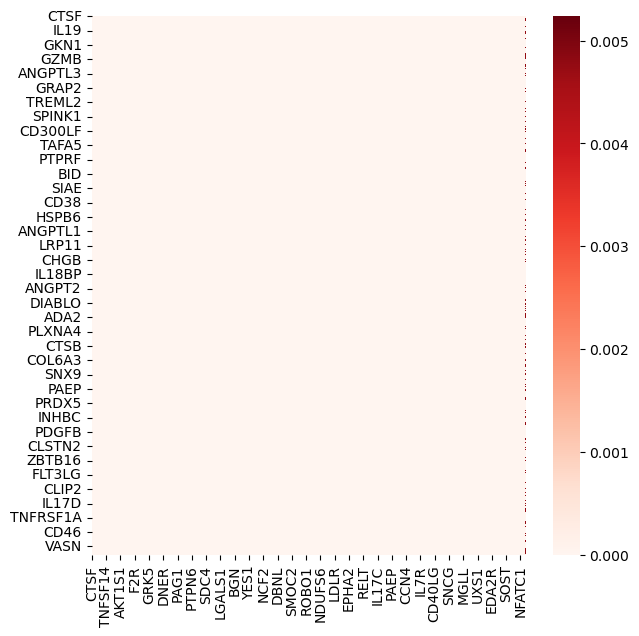

[1, 3, 5, 6, 15, 22, 24, 25, 32, 46, 54, 56, 57, 59, 60, 61, 62, 71, 72, 73, 74, 76, 84, 87, 105, 106, 110, 111, 124, 125, 135, 139, 147, 154, 161, 162, 164, 166, 169, 174, 179, 181, 186, 193, 195, 196, 197, 198, 209, 212, 214, 222, 223, 228, 242, 245, 248, 253, 260, 268, 269, 283, 284, 290, 298, 299, 300, 307, 312, 316, 319, 323, 327, 329, 334, 335, 338, 342, 345, 349, 356, 357, 359, 363, 366, 369, 373, 376, 391, 394, 397, 398, 403, 404, 415, 416, 417, 420, 421, 422, 425, 426, 428, 431, 432, 435, 437, 438, 440, 441, 451, 455, 457, 467, 468, 470, 474, 476, 479, 481, 484, 485, 494, 502, 503, 504, 508, 510, 512, 513, 517, 519, 523, 525, 527, 530, 532, 540, 542, 543, 546, 547, 548, 549, 559, 560, 562, 578, 581, 586, 588, 595, 597, 598, 599, 605, 615, 619, 620, 624, 625, 627, 632, 635, 643, 647, 651, 653, 659, 665, 666, 669, 675, 683, 687, 692, 697, 698, 700, 702, 709, 710, 714, 717, 721, 723, 724, 726, 740, 741, 742, 743, 748, 757, 758, 761, 763, 768, 769, 770, 779, 780, 781, 782, 783, 78

<Figure size 640x480 with 0 Axes>

In [61]:
max_value = np.float64(0)
min_value = np.float64(0)


tp_indices_article = []


for row in range(0,len(precision_M)):
    #max_value = np.float64(max(precision_M[row,:]))
    
    
    #if(max(precision_M[row,:])>0):
    #    print(max(precision_M[row,:]>0))
    #else:
    #    print(max(precision_M[row,:]>0))
    if(max(precision_M[row,:])>0):
        tp_indices_article.append(row)
     
    if(max(precision_M[row,:])>max_value):
        if(max(precision_M[row,:])<1):
            max_value = np.float64(max(precision_M[row,:]))
            
    
    if(min(precision_M[row,:])>min_value):
        min_value = np.float64(min(precision_M[row,:]))
        
    print("Max value: ", max_value, ". Min value: ",min_value) 
    

if(max_value==0):
    max_value = np.float64(0.001)
    
    
plt.figure(figsize = (7,7))   
df_precision_M = pd.DataFrame(precision_M, columns = df_train.iloc[:,:-2].columns, index = df_train.iloc[:,:-2].columns )
df_precision_M
ax = sns.heatmap(df_precision_M,vmin=min_value, vmax=max_value*1.1, cmap="Reds")
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/ClassifierChains/CM_ClassifierChains_" + split_factor_file_train + "_article.eps", transparent=True, format='png')

plt.show()
plt.clf()

#rows que testaram true positive    
proteins_confusion_matrix_article = []
print(tp_indices_article)
if (len(tp_indices_article)>0):
    for i in tp_indices_article:
        proteins_confusion_matrix_article.append(df_train.columns[i])
        print(df_train.columns[i])
    proteins_confusion_matrix_article.append(max_value)
    pd.DataFrame(proteins_confusion_matrix_article).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/ClassifierChains/true_positive_proteins_Age_BMI_" + split_factor_file_train + ".csv") 

### Label PowerSet - Funciona OK

In [62]:
%%time
label = LabelPowerset(classifier = SVC())
label.fit(X_train, y_train)
previsoes = label.predict(X_test)
print(hamming_loss(y_test,previsoes))

0.002531645569620253
CPU times: user 1.09 s, sys: 10.8 ms, total: 1.1 s
Wall time: 1.12 s


In [63]:
from sklearn.metrics import classification_report

labels = df_train.columns
len(labels)
label_names = labels[:-2]

print(classification_report(y_test, previsoes,target_names=label_names,zero_division=1))
#print(classification_report(y_test, previsto,target_names=label_names,zero_division=1))

from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test, previsoes, average='macro',zero_division=1))


#print(precision_recall_fscore_support(y_test, previsto, average='micro',zero_division=1))

#print(precision_recall_fscore_support(y_test, previsto, average='weighted',zero_division=1))




                precision    recall  f1-score   support

          CTSF       1.00      1.00      1.00         0
         CRHBP       1.00      0.00      0.00         1
          WIF1       1.00      1.00      1.00         0
         EGFL7       1.00      0.00      0.00         1
          CLPS       1.00      1.00      1.00         0
          GGT1       1.00      0.00      0.00         1
       CEACAM1       1.00      0.00      0.00         1
        EFEMP1       1.00      1.00      1.00         0
         CCL17       1.00      1.00      1.00         0
          ABL1       1.00      1.00      1.00         0
        SPINK4       1.00      1.00      1.00         0
         NTRK3       1.00      1.00      1.00         0
      SERPINB6       1.00      1.00      1.00         0
          CFC1       1.00      1.00      1.00         0
         IGSF8       1.00      1.00      1.00         0
          NRP1       1.00      0.00      0.00         1
         STK11       1.00      1.00      1.00  

In [64]:
from sklearn.metrics import f1_score

def f1_sampled(actual, pred):
    #converting the multi-label classification to a binary output
    #fitting the data for calculating the f1 score 
    f1 = f1_score(actual, pred, average = "macro",zero_division=1)
    return f1


print(f1_sampled(y_test, previsoes))

0.730379746835443


0.0
0.730379746835443
0.0
0.0
[[[211   0]
  [  0   0]]

 [[210   0]
  [  1   0]]

 [[211   0]
  [  0   0]]

 ...

 [[210   0]
  [  1   0]]

 [[210   0]
  [  1   0]]

 [[210   0]
  [  1   0]]]
790
[]


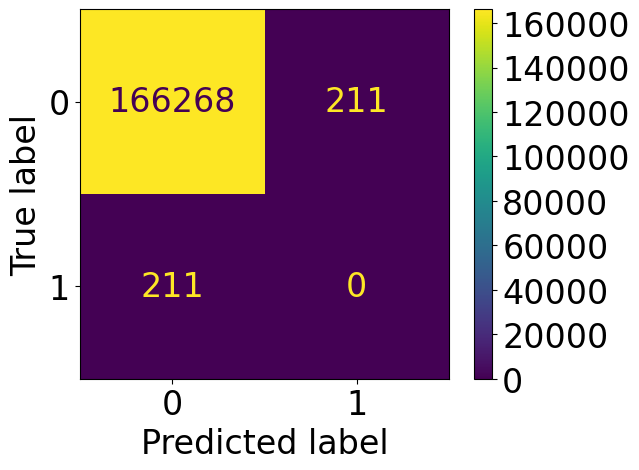

<Figure size 640x480 with 0 Axes>

In [65]:
from sklearn.metrics import jaccard_score
print(jaccard_score(previsoes.A,y_test, average='samples', zero_division=True))
print(jaccard_score(y_test,previsoes.A, average='macro',zero_division=True))
print(jaccard_score(y_test,previsoes.A, average='weighted',zero_division=True))
print(jaccard_score(y_test,previsoes.A, average='micro',zero_division=True))

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
print(multilabel_confusion_matrix(y_test, previsao))


matrices = multilabel_confusion_matrix(y_test, previsoes.A)

cm = confusion_matrix(y_test.ravel(), previsoes.A.ravel())

plt.rcParams.update({'font.size': 24})
# Create a ConfusionMatrixDisplay object
#cmd = ConfusionMatrixDisplay(cm, display_labels=[f"Class {i}" for i in range(2)])
cmd = ConfusionMatrixDisplay.from_predictions(y_test.ravel(), previsoes.A.ravel(),values_format='')
# Display the confusion matrix
cmd.plot()
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/LabelPowerSet/CM_LabelPowerSet_" + split_factor_file_train + "_flattened.eps", transparent=True, format='png', bbox_inches='tight')
plt.rcParams.update({'font.size': 10})
plt.clf()


num_classes = len(matrices)
print(num_classes)
# Initialize an empty list to store the true positive row indices
tp_indices = []

# Iterate over each class
for i in range(num_classes):
    # Get the confusion matrix for the current class
    class_cm = matrices[i]
    #print(class_cm.shape)
    
    # Extract the true positive count from the confusion matrix
    tp = class_cm[1, 1]
    
    # If the true positive count is greater than 0, add the index to the list
    if tp > 0:
        tp_indices.append(i)


#rows que testaram true positive        
print(tp_indices)
proteins_confusion_matrix_flattened = []
if (len(tp_indices)>0):
    for i in tp_indices:
        print(df_train.columns[i])
        proteins_confusion_matrix_flattened.append(df_train.columns[i])
    pd.DataFrame(proteins_confusion_matrix_flattened).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/LabelPowerSet/true_positive_proteins__flattened_Age_BMI_" + split_factor_file_train + ".csv") 
 
#define rows to add
rows_to_append = pd.DataFrame([{'Model':'Label Powerset SVC', 'Proportion':split_factor_file_train, 
                                'HL':hamming_loss(y_test, previsoes),
                               'Prec':precision_recall_fscore_support(y_test, previsoes, average='macro',zero_division=1)[0],
                               'Rec':precision_recall_fscore_support(y_test, previsoes, average='macro',zero_division=1)[1],
                               'F1':precision_recall_fscore_support(y_test, previsoes, average='macro',zero_division=1)[2],
                               'Jac':jaccard_score(y_test,previsoes, average='macro',zero_division=True)}])
                           

#add row to empty DataFrame
df_model_scores = pd.concat([df_model_scores, rows_to_append])

df_model_scores.head(20)

row_to_append = pd.DataFrame([{'Model' : 'LPS SVM', 'Split' : split_factor_file_train, 'TP' : cm[1,1], 'Sorting' : 'BMI (given Age)'}])
df_TP_CM = pd.concat([df_TP_CM,row_to_append])

(211, 790)
(211, 790)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
M is  (790, 790)
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  1 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0


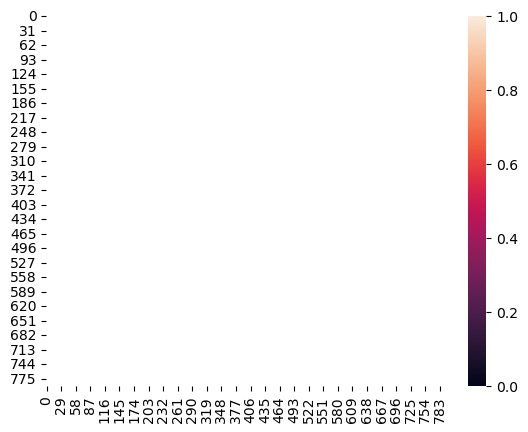

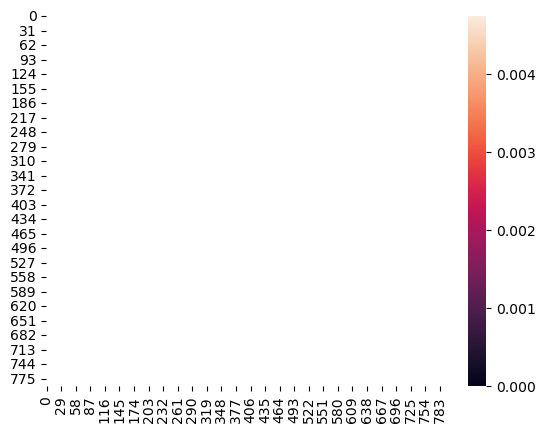

In [66]:
#y_test is already ndarray
Z = previsoes.A
print(Z.shape)
Y = y_test
print(Y.shape)
M = confusion_matrix_article(Y,Z)
precision_M = precision_matrix(M)

ax = sns.heatmap(M, linewidth=0.5)
plt.show()

ax = sns.heatmap(precision_M, linewidth=0.5)
plt.show()

### Confusion Matrix Article

Max value:  0.0 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0.0
Max value:  0.004739336492890996 . Min value:  0

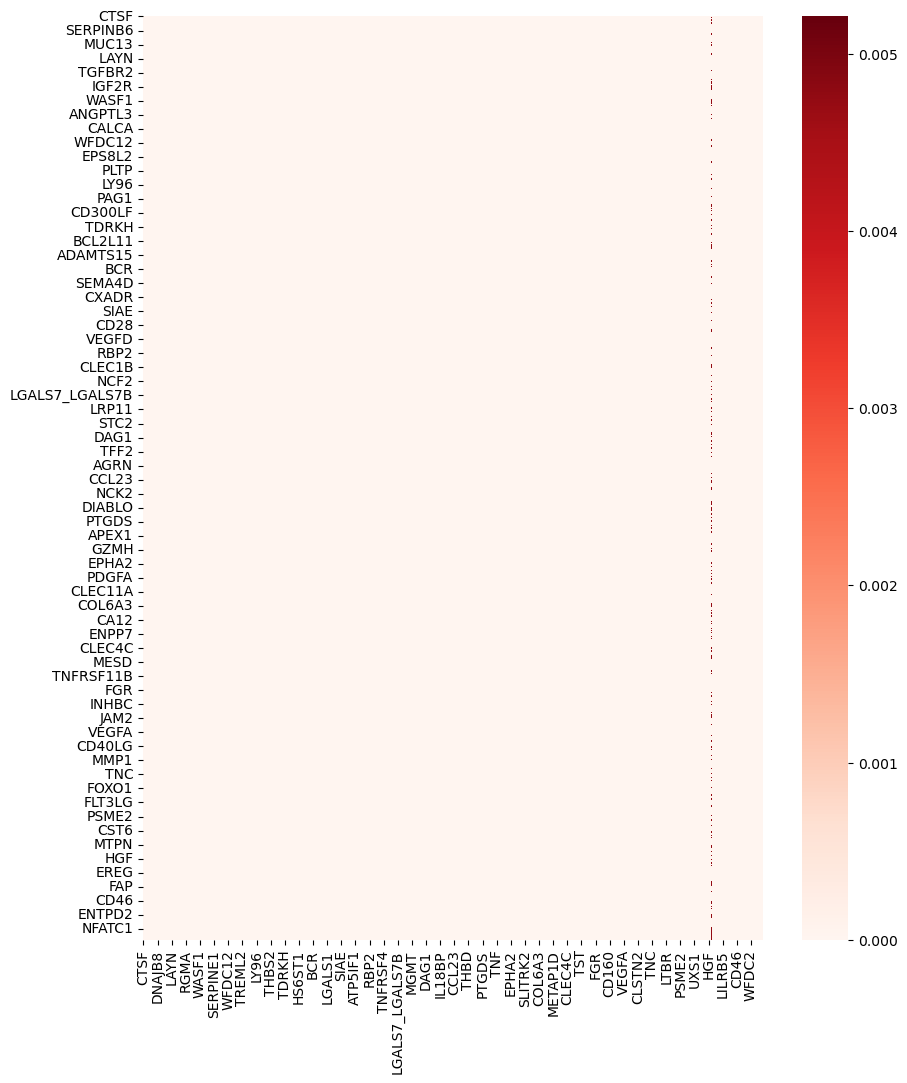

[1, 3, 5, 6, 15, 22, 24, 25, 32, 46, 54, 56, 57, 59, 60, 61, 62, 71, 72, 73, 74, 76, 84, 87, 105, 106, 110, 111, 124, 125, 135, 139, 147, 154, 161, 162, 164, 166, 169, 174, 179, 181, 186, 193, 195, 196, 197, 198, 209, 212, 214, 222, 223, 228, 242, 245, 248, 253, 260, 268, 269, 283, 284, 290, 298, 299, 300, 307, 312, 316, 319, 323, 327, 329, 334, 335, 338, 342, 345, 349, 356, 357, 359, 363, 366, 369, 373, 376, 391, 394, 397, 398, 403, 404, 415, 416, 417, 420, 421, 422, 425, 426, 428, 431, 432, 435, 437, 438, 440, 441, 451, 455, 457, 467, 468, 470, 474, 476, 479, 481, 484, 485, 494, 502, 503, 504, 508, 510, 512, 513, 517, 519, 523, 525, 527, 530, 532, 540, 542, 543, 546, 547, 548, 549, 559, 560, 562, 578, 581, 586, 588, 595, 597, 598, 599, 605, 615, 619, 620, 624, 625, 627, 632, 635, 643, 647, 651, 653, 659, 665, 666, 669, 675, 683, 687, 692, 697, 698, 700, 702, 709, 710, 714, 717, 721, 723, 724, 726, 740, 741, 742, 743, 748, 757, 758, 761, 763, 768, 769, 770, 779, 780, 781, 782, 783, 78

<Figure size 640x480 with 0 Axes>

In [67]:
max_value = np.float64(0)
min_value = np.float64(0)


tp_indices_article = []


for row in range(0,len(precision_M)):
    #max_value = np.float64(max(precision_M[row,:]))
    
    
    #if(max(precision_M[row,:])>0):
    #    print(max(precision_M[row,:]>0))
    #else:
    #    print(max(precision_M[row,:]>0))
    if(max(precision_M[row,:])>0):
        tp_indices_article.append(row)
     
    if(max(precision_M[row,:])>max_value):
        if(max(precision_M[row,:])<1):
            max_value = np.float64(max(precision_M[row,:]))
            
    
    if(min(precision_M[row,:])>min_value):
        min_value = np.float64(min(precision_M[row,:]))
        
    print("Max value: ", max_value, ". Min value: ",min_value) 
    

if(max_value==0):
    max_value = np.float64(0.001)
    
    
plt.figure(figsize = (10,12))   
df_precision_M = pd.DataFrame(precision_M, columns = df_train.iloc[:,:-2].columns, index = df_train.iloc[:,:-2].columns )
df_precision_M
ax = sns.heatmap(df_precision_M,vmin=min_value, vmax=max_value*1.1, cmap="Reds")
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/LabelPowerSet/CM_LabelPowerSet_" + split_factor_file_train + "_article.eps", transparent=True, format='png')

plt.show()
plt.clf()

#rows que testaram true positive    
proteins_confusion_matrix_article = []
print(tp_indices_article)
if (len(tp_indices_article)>0):
    for i in tp_indices_article:
        proteins_confusion_matrix_article.append(df_train.columns[i])
        print(df_train.columns[i])
    proteins_confusion_matrix_article.append(max_value)
    pd.DataFrame(proteins_confusion_matrix_article).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/LabelPowerSet/true_positive_proteins_Age_BMI_" + split_factor_file_train + ".csv") 

### RandomForest - Funciona OK

In [68]:
%%time
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf = clf.fit(X_train, y_train)

CPU times: user 9.85 s, sys: 424 ms, total: 10.3 s
Wall time: 6.64 s


In [69]:
#Test
predicted_labels = clf.predict(X_test)
print(hamming_loss(y_test,predicted_labels))
    

0.0012658227848101266


In [70]:
from sklearn.metrics import classification_report

labels = df_train.columns
len(labels)
label_names = labels[:-2]

print(classification_report(y_test, predicted_labels,target_names=label_names,zero_division=1))
#print(classification_report(y_test, previsto,target_names=label_names,zero_division=1))

from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test, predicted_labels, average='macro',zero_division=1))


#print(precision_recall_fscore_support(y_test, previsto, average='micro',zero_division=1))

#print(precision_recall_fscore_support(y_test, previsto, average='weighted',zero_division=1))




                precision    recall  f1-score   support

          CTSF       1.00      1.00      1.00         0
         CRHBP       1.00      0.00      0.00         1
          WIF1       1.00      1.00      1.00         0
         EGFL7       1.00      0.00      0.00         1
          CLPS       1.00      1.00      1.00         0
          GGT1       1.00      0.00      0.00         1
       CEACAM1       1.00      0.00      0.00         1
        EFEMP1       1.00      1.00      1.00         0
         CCL17       1.00      1.00      1.00         0
          ABL1       1.00      1.00      1.00         0
        SPINK4       1.00      1.00      1.00         0
         NTRK3       1.00      1.00      1.00         0
      SERPINB6       1.00      1.00      1.00         0
          CFC1       1.00      1.00      1.00         0
         IGSF8       1.00      1.00      1.00         0
          NRP1       1.00      0.00      0.00         1
         STK11       1.00      1.00      1.00  

In [71]:
from sklearn.metrics import f1_score

def f1_sampled(actual, pred):
    #converting the multi-label classification to a binary output
    #fitting the data for calculating the f1 score 
    f1 = f1_score(actual, pred, average = "macro",zero_division=1)
    return f1


print(f1_sampled(y_test, predicted_labels))

0.7329113924050633


0.0
0.7329113924050633
0.0
0.0
[[[211   0]
  [  0   0]]

 [[210   0]
  [  1   0]]

 [[211   0]
  [  0   0]]

 ...

 [[210   0]
  [  1   0]]

 [[210   0]
  [  1   0]]

 [[210   0]
  [  1   0]]]
790
[]


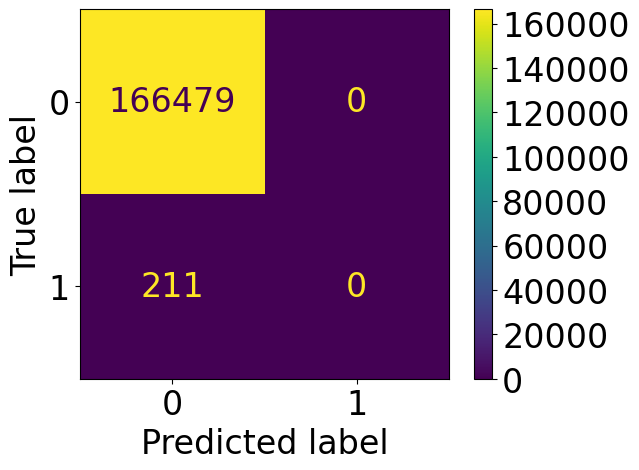

<Figure size 640x480 with 0 Axes>

In [72]:
from sklearn.metrics import jaccard_score
print(jaccard_score(predicted_labels,y_test, average='samples', zero_division=True))
print(jaccard_score(y_test,predicted_labels, average='macro',zero_division=True))
print(jaccard_score(y_test,predicted_labels, average='weighted',zero_division=True))
print(jaccard_score(y_test,predicted_labels, average='micro',zero_division=True))

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
print(multilabel_confusion_matrix(y_test, previsao))


matrices = multilabel_confusion_matrix(y_test, predicted_labels)

cm = confusion_matrix(y_test.ravel(), predicted_labels.ravel())
plt.rcParams.update({'font.size': 24})
# Create a ConfusionMatrixDisplay object
#cmd = ConfusionMatrixDisplay(cm, display_labels=[f"Class {i}" for i in range(2)])
cmd = ConfusionMatrixDisplay.from_predictions(y_test.ravel(), predicted_labels.ravel(),values_format='')
# Display the confusion matrix
cmd.plot()
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/RandomForest/CM_RandomForest_" + split_factor_file_train + "_flattened.eps", transparent=True, format='png', bbox_inches='tight')
plt.rcParams.update({'font.size': 10})
plt.clf()

                                    
                    
num_classes = len(matrices)
print(num_classes)
# Initialize an empty list to store the true positive row indices
tp_indices = []

# Iterate over each class
for i in range(num_classes):
    # Get the confusion matrix for the current class
    class_cm = matrices[i]
    #print(class_cm.shape)
    
    # Extract the true positive count from the confusion matrix
    tp = class_cm[1, 1]
    
    # If the true positive count is greater than 0, add the index to the list
    if tp > 0:
        tp_indices.append(i)


#rows que testaram true positive        
print(tp_indices)
proteins_confusion_matrix_flattened = []
if (len(tp_indices)>0):
    for i in tp_indices:
        print(df_train.columns[i])
        proteins_confusion_matrix_flattened.append(df_train.columns[i])
    pd.DataFrame(proteins_confusion_matrix_flattened).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/RandomForest/true_positive_proteins__flattened_Age_BMI_" + split_factor_file_train + ".csv") 
 
        
    
#define rows to add
rows_to_append = pd.DataFrame([{'Model':'RandomForest', 'Proportion':split_factor_file_train, 
                                'HL':hamming_loss(y_test, predicted_labels),
                               'Prec':precision_recall_fscore_support(y_test, predicted_labels, average='macro',zero_division=1)[0],
                               'Rec':precision_recall_fscore_support(y_test, predicted_labels, average='macro',zero_division=1)[1],
                               'F1':precision_recall_fscore_support(y_test, predicted_labels, average='macro',zero_division=1)[2],
                               'Jac':jaccard_score(y_test,predicted_labels, average='macro',zero_division=True)}])
                           

#add row to empty DataFrame
df_model_scores = pd.concat([df_model_scores, rows_to_append])

df_model_scores.head()

row_to_append = pd.DataFrame([{'Model' : 'RF', 'Split' : split_factor_file_train, 'TP' : cm[1,1], 'Sorting' : 'BMI (given Age)'}])
df_TP_CM = pd.concat([df_TP_CM,row_to_append])

(211, 790)
(211, 790)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
M is  (790, 790)
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  0
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  1
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  2
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0

|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  30
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  31
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  32
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape 

|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  71
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  72
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  73
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape 

kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  109
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  110
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  111
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0

|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  146
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  147
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  148
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , sha

kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  185
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  186
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  187
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0

precision_M =  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


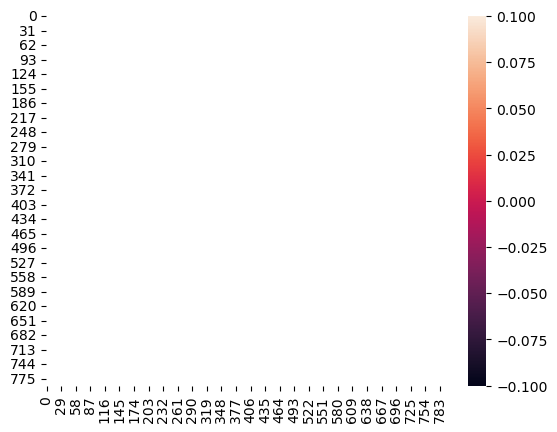

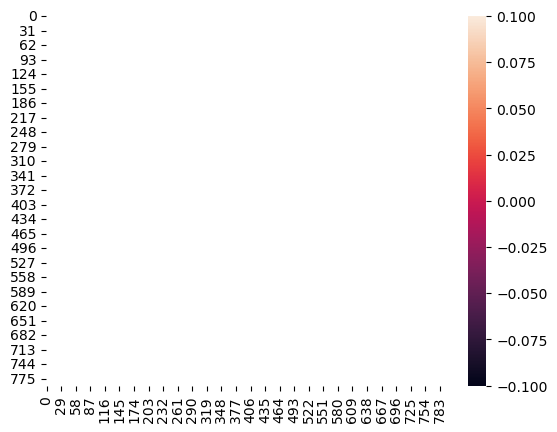

In [73]:
#y_test is already ndarray
Z = predicted_labels
print(Z.shape)
Y = y_test
print(Y.shape)
M = confusion_matrix_article(Y,Z)
precision_M = precision_matrix(M)

ax = sns.heatmap(M, linewidth=0.5)
plt.show()

ax = sns.heatmap(precision_M, linewidth=0.5)
plt.show()

### Confusion Matrix Article

Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.

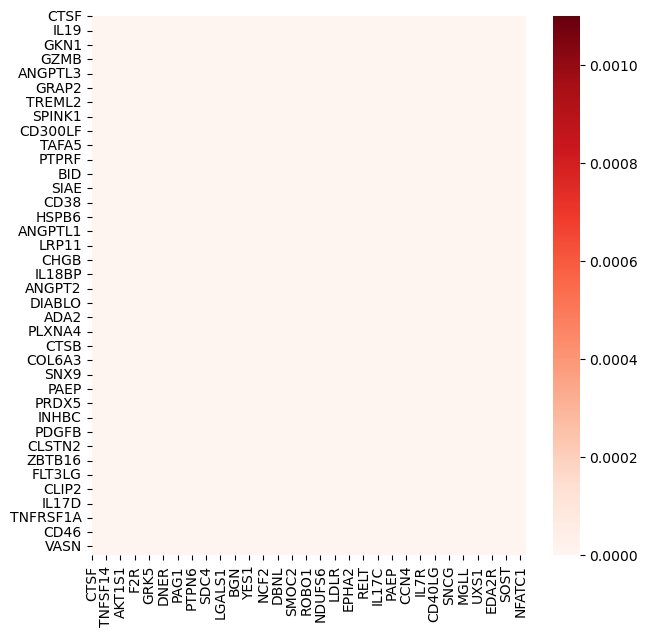

[]


<Figure size 640x480 with 0 Axes>

In [74]:
max_value = np.float64(0)
min_value = np.float64(0)


tp_indices_article = []


for row in range(0,len(precision_M)):
    #max_value = np.float64(max(precision_M[row,:]))
    
    
    #if(max(precision_M[row,:])>0):
    #    print(max(precision_M[row,:]>0))
    #else:
    #    print(max(precision_M[row,:]>0))
    if(max(precision_M[row,:])>0):
        tp_indices_article.append(row)
     
    if(max(precision_M[row,:])>max_value):
        if(max(precision_M[row,:])<1):
            max_value = np.float64(max(precision_M[row,:]))
            
    
    if(min(precision_M[row,:])>min_value):
        min_value = np.float64(min(precision_M[row,:]))
        
    print("Max value: ", max_value, ". Min value: ",min_value) 
    

if(max_value==0):
    max_value = np.float64(0.001)
    
    
plt.figure(figsize = (7,7))   
df_precision_M = pd.DataFrame(precision_M, columns = df_train.iloc[:,:-2].columns, index = df_train.iloc[:,:-2].columns )
df_precision_M
ax = sns.heatmap(df_precision_M,vmin=min_value, vmax=max_value*1.1, cmap="Reds")
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/RandomForest/CM_RandomForest_" + split_factor_file_train + "_article.eps", transparent=True, format='png')

plt.show()
plt.clf()

#rows que testaram true positive    
proteins_confusion_matrix_article = []
print(tp_indices_article)
if (len(tp_indices_article)>0):
    for i in tp_indices_article:
        proteins_confusion_matrix_article.append(df_train.columns[i])
        print(df_train.columns[i])
    proteins_confusion_matrix_article.append(max_value)
    pd.DataFrame(proteins_confusion_matrix_article).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/RandomForest/true_positive_proteins_Age_BMI_" + split_factor_file_train + ".csv") 

### Decision Tree

In [75]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
clf = DecisionTreeClassifier(random_state=100)
clf = clf.fit(X_train, y_train)

CPU times: user 58.6 ms, sys: 1.85 ms, total: 60.4 ms
Wall time: 59.2 ms


In [76]:
#Test
predicted_labels = clf.predict(X_test)
print(hamming_loss(y_test,predicted_labels))

0.0012658227848101266


In [77]:
from sklearn.metrics import classification_report

labels = df_train.columns
len(labels)
label_names = labels[:-2]

print(classification_report(y_test, predicted_labels,target_names=label_names,zero_division=1))
#print(classification_report(y_test, previsto,target_names=label_names,zero_division=1))

from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test, predicted_labels, average='macro',zero_division=1))


#print(precision_recall_fscore_support(y_test, previsto, average='micro',zero_division=1))

#print(precision_recall_fscore_support(y_test, previsto, average='weighted',zero_division=1))




                precision    recall  f1-score   support

          CTSF       1.00      1.00      1.00         0
         CRHBP       1.00      0.00      0.00         1
          WIF1       1.00      1.00      1.00         0
         EGFL7       1.00      0.00      0.00         1
          CLPS       1.00      1.00      1.00         0
          GGT1       1.00      0.00      0.00         1
       CEACAM1       1.00      0.00      0.00         1
        EFEMP1       1.00      1.00      1.00         0
         CCL17       1.00      1.00      1.00         0
          ABL1       1.00      1.00      1.00         0
        SPINK4       1.00      1.00      1.00         0
         NTRK3       1.00      1.00      1.00         0
      SERPINB6       1.00      1.00      1.00         0
          CFC1       1.00      1.00      1.00         0
         IGSF8       1.00      1.00      1.00         0
          NRP1       1.00      0.00      0.00         1
         STK11       1.00      1.00      1.00  

In [78]:
from sklearn.metrics import f1_score

def f1_sampled(actual, pred):
    #converting the multi-label classification to a binary output
    #fitting the data for calculating the f1 score 
    f1 = f1_score(actual, pred, average = "macro",zero_division=1)
    return f1


print(f1_sampled(y_test, predicted_labels))

0.7329113924050633


0.0
0.7329113924050633
0.0
0.0
[[[211   0]
  [  0   0]]

 [[210   0]
  [  1   0]]

 [[211   0]
  [  0   0]]

 ...

 [[210   0]
  [  1   0]]

 [[210   0]
  [  1   0]]

 [[210   0]
  [  1   0]]]
790
[]


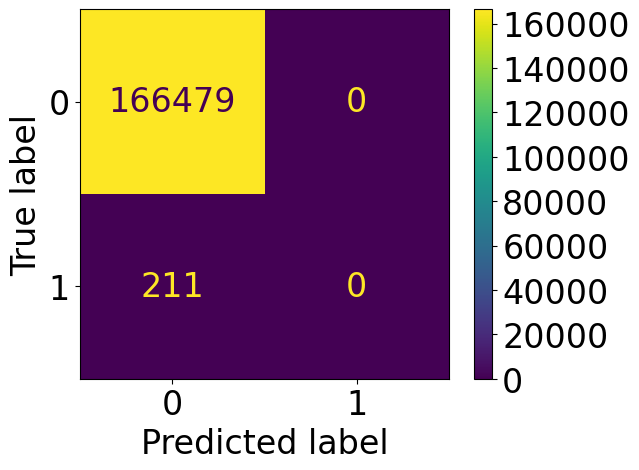

<Figure size 640x480 with 0 Axes>

In [79]:
from sklearn.metrics import jaccard_score
print(jaccard_score(predicted_labels,y_test, average='samples', zero_division=True))
print(jaccard_score(y_test,predicted_labels, average='macro',zero_division=True))
print(jaccard_score(y_test,predicted_labels, average='weighted',zero_division=True))
print(jaccard_score(y_test,predicted_labels, average='micro',zero_division=True))

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
print(multilabel_confusion_matrix(y_test, previsao))


matrices = multilabel_confusion_matrix(y_test, predicted_labels)

cm = confusion_matrix(y_test.ravel(), predicted_labels.ravel())
plt.rcParams.update({'font.size': 24})
# Create a ConfusionMatrixDisplay object
#cmd = ConfusionMatrixDisplay(cm, display_labels=[f"Class {i}" for i in range(2)])
cmd = ConfusionMatrixDisplay.from_predictions(y_test.ravel(), predicted_labels.ravel(),values_format='')
# Display the confusion matrix
cmd.plot()
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/DecisionTree/CM_DecisionTree_" + split_factor_file_train + "_flattened.eps", transparent=True, format='png', bbox_inches='tight')
plt.rcParams.update({'font.size': 10})
plt.clf()




num_classes = len(matrices)
print(num_classes)
# Initialize an empty list to store the true positive row indices
tp_indices = []

# Iterate over each class
for i in range(num_classes):
    # Get the confusion matrix for the current class
    class_cm = matrices[i]
    #print(class_cm.shape)
    
    # Extract the true positive count from the confusion matrix
    tp = class_cm[1, 1]
    
    # If the true positive count is greater than 0, add the index to the list
    if tp > 0:
        tp_indices.append(i)


#rows que testaram true positive        
print(tp_indices)
proteins_confusion_matrix_flattened = []
if (len(tp_indices)>0):
    for i in tp_indices:
        print(df_train.columns[i])
        proteins_confusion_matrix_flattened.append(df_train.columns[i])
    pd.DataFrame(proteins_confusion_matrix_flattened).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/DecisionTree/true_positive_proteins__flattened_Age_BMI_" + split_factor_file_train + ".csv") 
 

#define rows to add
rows_to_append = pd.DataFrame([{'Model':'DecisionTree', 'Proportion':split_factor_file_train, 
                                'HL':hamming_loss(y_test, predicted_labels),
                               'Prec':precision_recall_fscore_support(y_test, predicted_labels, average='macro',zero_division=1)[0],
                               'Rec':precision_recall_fscore_support(y_test, predicted_labels, average='macro',zero_division=1)[1],
                               'F1':precision_recall_fscore_support(y_test, predicted_labels, average='macro',zero_division=1)[2],
                               'Jac':jaccard_score(y_test,predicted_labels, average='macro',zero_division=True)}])
                           

#add row to empty DataFrame
df_model_scores = pd.concat([df_model_scores, rows_to_append])

df_model_scores.head()

row_to_append = pd.DataFrame([{'Model' : 'DT', 'Split' : split_factor_file_train, 'TP' : cm[1,1], 'Sorting' : 'BMI (given Age)'}])
df_TP_CM = pd.concat([df_TP_CM,row_to_append])

(211, 790)
(211, 790)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
M is  (790, 790)
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  0
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  1
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  2
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0

kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  41
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  42
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  43
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0

Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  83
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  84
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  85
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 

kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  126
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  127
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  128
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0

Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  168
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  169
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  170
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 

|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  210
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
M =  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
precision_M =  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


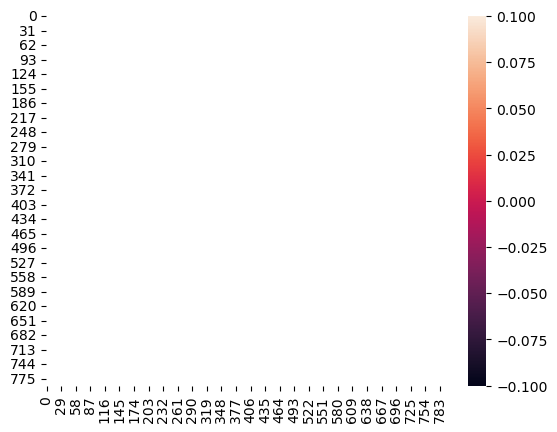

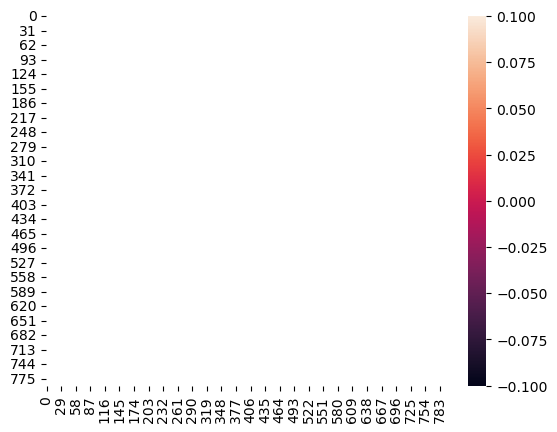

In [80]:
#y_test is already ndarray
Z = predicted_labels
print(Z.shape)
Y = y_test
print(Y.shape)
M = confusion_matrix_article(Y,Z)
precision_M = precision_matrix(M)

ax = sns.heatmap(M, linewidth=0.5)
plt.show()

ax = sns.heatmap(precision_M, linewidth=0.5)
plt.show()

### Confusion Matrix Article

Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.

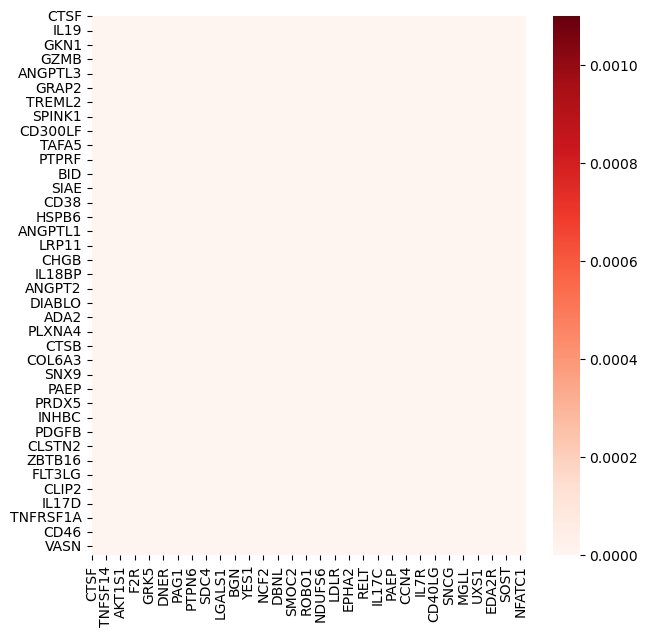

[]


<Figure size 640x480 with 0 Axes>

In [81]:
max_value = np.float64(0)
min_value = np.float64(0)


tp_indices_article = []


for row in range(0,len(precision_M)):
    #max_value = np.float64(max(precision_M[row,:]))
    
    
    #if(max(precision_M[row,:])>0):
    #    print(max(precision_M[row,:]>0))
    #else:
    #    print(max(precision_M[row,:]>0))
    if(max(precision_M[row,:])>0):
        tp_indices_article.append(row)
     
    if(max(precision_M[row,:])>max_value):
        if(max(precision_M[row,:])<1):
            max_value = np.float64(max(precision_M[row,:]))
            
    
    if(min(precision_M[row,:])>min_value):
        min_value = np.float64(min(precision_M[row,:]))
        
    print("Max value: ", max_value, ". Min value: ",min_value) 
    

if(max_value==0):
    max_value = np.float64(0.001)
    
    
plt.figure(figsize = (7,7))   
df_precision_M = pd.DataFrame(precision_M, columns = df_train.iloc[:,:-2].columns, index = df_train.iloc[:,:-2].columns )
df_precision_M
ax = sns.heatmap(df_precision_M,vmin=min_value, vmax=max_value*1.1, cmap="Reds")
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/DecisionTree/CM_DecisionTree_" + split_factor_file_train + "_article.eps", transparent=True, format='png')

plt.show()
plt.clf()

#rows que testaram true positive    
proteins_confusion_matrix_article = []
print(tp_indices_article)
if (len(tp_indices_article)>0):
    for i in tp_indices_article:
        proteins_confusion_matrix_article.append(df_train.columns[i])
        print(df_train.columns[i])
    proteins_confusion_matrix_article.append(max_value)
    pd.DataFrame(proteins_confusion_matrix_article).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/DecisionTree/true_positive_proteins_Age_BMI_" + split_factor_file_train + ".csv") 

### Support Vector Machine

In [82]:
%%time
from skmultilearn.adapt import MLTSVM
from scipy import sparse

classifier = MLTSVM(c_k = 2**-1)

X_train = sparse.csr_matrix(X_train)
y_train = sparse.csr_matrix(y_train)
y_test = sparse.csr_matrix(y_test)
print(type(X_train),type(y_train))
# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)
print(hamming_loss(y_test,predictions))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
0.17223588697582337
CPU times: user 2min 31s, sys: 323 ms, total: 2min 31s
Wall time: 2min 31s


In [83]:
from sklearn.metrics import classification_report

labels = df_train.columns
len(labels)
label_names = labels[:-2]

print(classification_report(y_test, predictions,target_names=label_names,zero_division=1))
#print(classification_report(y_test, previsto,target_names=label_names,zero_division=1))

from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test, predictions, average='macro',zero_division=1))


#print(precision_recall_fscore_support(y_test, previsto, average='micro',zero_division=1))

#print(precision_recall_fscore_support(y_test, previsto, average='weighted',zero_division=1))


                precision    recall  f1-score   support

          CTSF       1.00      1.00      1.00         0
         CRHBP       0.01      1.00      0.01         1
          WIF1       0.00      1.00      0.00         0
         EGFL7       0.01      1.00      0.01         1
          CLPS       0.00      1.00      0.00         0
          GGT1       0.00      0.00      0.00         1
       CEACAM1       1.00      0.00      0.00         1
        EFEMP1       0.00      1.00      0.00         0
         CCL17       1.00      1.00      1.00         0
          ABL1       1.00      1.00      1.00         0
        SPINK4       1.00      1.00      1.00         0
         NTRK3       0.00      1.00      0.00         0
      SERPINB6       0.00      1.00      0.00         0
          CFC1       0.00      1.00      0.00         0
         IGSF8       1.00      1.00      1.00         0
          NRP1       0.01      1.00      0.01         1
         STK11       1.00      1.00      1.00  

In [84]:
from sklearn.metrics import f1_score

def f1_sampled(actual, pred):
    #converting the multi-label classification to a binary output
    #fitting the data for calculating the f1 score 
    f1 = f1_score(actual, pred, average = "macro",zero_division=1)
    return f1


print(f1_sampled(y_test, predictions))

0.3542278481012658


0.0011643696758967062
0.3538027691198609
0.002389514714171172
0.001217603061401983
[[[211   0]
  [  0   0]]

 [[ 12 198]
  [  0   1]]

 [[208   3]
  [  0   0]]

 ...

 [[210   0]
  [  1   0]]

 [[207   3]
  [  1   0]]

 [[210   0]
  [  1   0]]]
<class 'scipy.sparse._csr.csr_matrix'>
790
[1, 3, 15, 22, 59, 106, 186, 214, 248, 300, 312, 319, 323, 335, 394, 416, 441, 470, 476, 484, 517, 527, 560, 586, 597, 599, 625, 643, 647, 659, 665, 675, 702, 741, 748]
CRHBP
EGFL7
NRP1
DNMBP
ICAM1
SORT1
CD40
ANXA11
NCR1
CLEC1B
NCF2
CNPY4
NRP2
IL2RA
TXNDC5
NDUFS6
ADA2
PECAM1
PRKRA
LAT
SCAMP3
ADAM22
BOC
CST5
CDCP1
ENPP2
ROR1
MEGF10
CCDC80
PON3
CST3
KLRD1
UXS1
DBI
TFF1


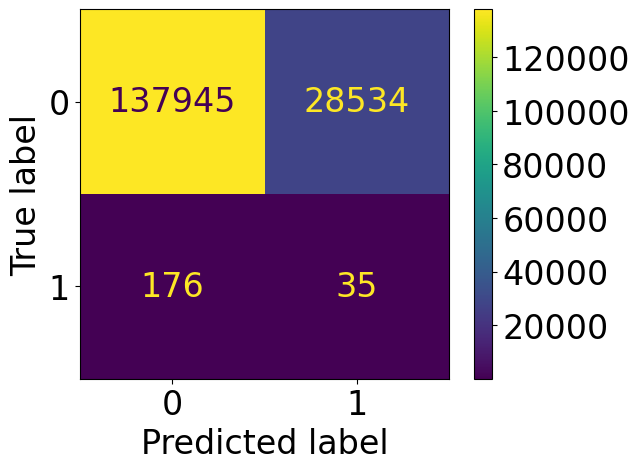

<Figure size 640x480 with 0 Axes>

In [85]:
from sklearn.metrics import jaccard_score
print(jaccard_score(predictions,y_test, average='samples', zero_division=True))
print(jaccard_score(y_test,predictions, average='macro',zero_division=True))
print(jaccard_score(y_test,predictions, average='weighted',zero_division=True))
print(jaccard_score(y_test,predictions, average='micro',zero_division=True))

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
print(multilabel_confusion_matrix(y_test, predictions))


matrices = multilabel_confusion_matrix(y_test, predictions)

print(type(y_test))

cm = confusion_matrix(y_test.A.ravel(), predictions.ravel())
plt.rcParams.update({'font.size': 24})
# Create a ConfusionMatrixDisplay object
#cmd = ConfusionMatrixDisplay(cm, display_labels=[f"Class {i}" for i in range(2)])
cmd = ConfusionMatrixDisplay.from_predictions(y_test.A.ravel(), predictions.ravel(),values_format='')
# Display the confusion matrix
cmd.plot()
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/SVM/CM_SVM_" + split_factor_file_train + "_flattened.eps", transparent=True, format='png', bbox_inches='tight')
plt.rcParams.update({'font.size': 10})
plt.clf()


num_classes = len(matrices)
print(num_classes)
# Initialize an empty list to store the true positive row indices
tp_indices = []

# Iterate over each class
for i in range(num_classes):
    # Get the confusion matrix for the current class
    class_cm = matrices[i]
    #print(class_cm.shape)
    
    # Extract the true positive count from the confusion matrix
    tp = class_cm[1, 1]
    
    # If the true positive count is greater than 0, add the index to the list
    if tp > 0:
        tp_indices.append(i)


#rows que testaram true positive        
print(tp_indices)
proteins_confusion_matrix_flattened = []
if (len(tp_indices)>0):
    for i in tp_indices:
        print(df_train.columns[i])
        proteins_confusion_matrix_flattened.append(df_train.columns[i])
    pd.DataFrame(proteins_confusion_matrix_flattened).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/SVM/true_positive_proteins__flattened_Age_BMI_" + split_factor_file_train + ".csv") 
 
        
#define rows to add
rows_to_append = pd.DataFrame([{'Model':'SVM', 'Proportion':split_factor_file_train, 
                                'HL':hamming_loss(y_test, predictions),
                               'Prec':precision_recall_fscore_support(y_test, predictions, average='macro',zero_division=1)[0],
                               'Rec':precision_recall_fscore_support(y_test, predictions, average='macro',zero_division=1)[1],
                               'F1':precision_recall_fscore_support(y_test, predictions, average='macro',zero_division=1)[2],
                               'Jac':jaccard_score(y_test,predictions, average='macro',zero_division=True)}])
                           

#add row to empty DataFrame
df_model_scores = pd.concat([df_model_scores, rows_to_append])

df_model_scores.head()

row_to_append = pd.DataFrame([{'Model' : 'SVM', 'Split' : split_factor_file_train, 'TP' : cm[1,1], 'Sorting' : 'BMI (given Age)'}])
df_TP_CM = pd.concat([df_TP_CM,row_to_append])

(211, 790)
(211, 790)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
M is  (790, 790)
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  2 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  2 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  2 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  2 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  2 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  0 , shape =  (790,)
|Zi\Yi| =  2 , shape =  (790,)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  2 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  2 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  2 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  2 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  2 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  2 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0


|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  2 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  2 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  2 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  2 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


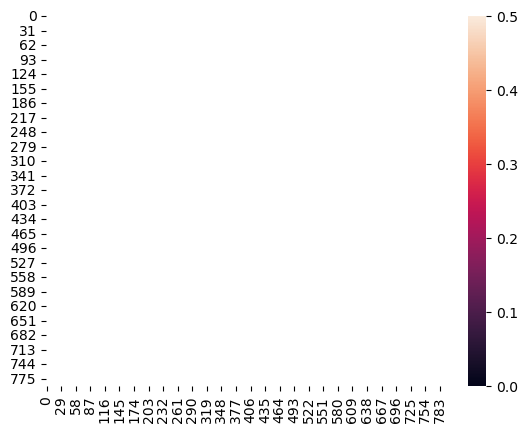

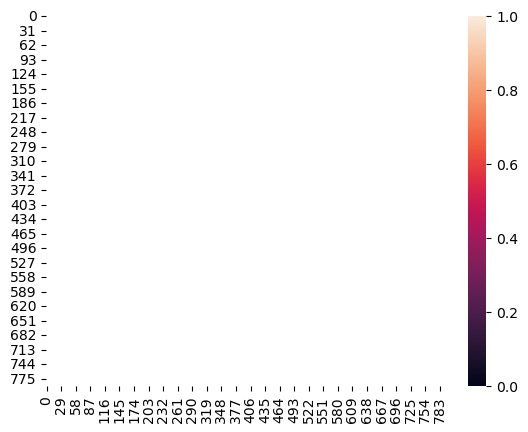

In [86]:
#y_test is already ndarray
Z = predictions
print(Z.shape)
Y = y_test.A
print(Y.shape)
M = confusion_matrix_article(Y,Z)
precision_M = precision_matrix(M)

ax = sns.heatmap(M, linewidth=0.5)
plt.show()

ax = sns.heatmap(precision_M, linewidth=0.5)
plt.show()

### Confusion Matrix Article

Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.005665999612206 . Min value:  0.0
Max value:  0.005665999612206 . Min value:  0.0
Max value:  0.005665999612206 . Min value:  0.0
Max value:  0.005665999612206 . Min value:  0.0
Max value:  0.005665999612206 . Min value:  0.0
Max value:  0.005665999612206 . Min value:  0.0
Max value:  0.005665999612206 . Min value:  0.0
Max value:  0.005665999612206 . Min value:  0.0
Max value:  0.005665999612206 . Min value:  0.0
Max value:  0.005665999612206 . Min value:  0.0
Max value:  0.005665999612206 . Min value:  0.0
Max value:  0.005665999612206 . Min value:  0.0
Max value:  0.005665999612206 . Min value:  0.0
Max value:  0.005665999612206 . Min value:  0.0
Max value:  0.005665999612206 . Min value:  0.0
Max value:  0.005665999612206 . Min value:  0.0
Max value:  0.005665999612206 . Min value:  0.0
Max value:  0.

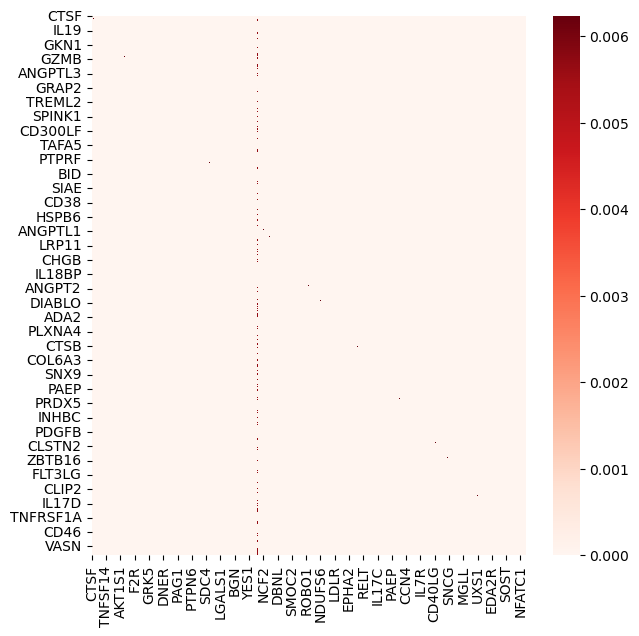

[1, 3, 5, 6, 15, 22, 24, 25, 32, 46, 54, 56, 57, 59, 60, 61, 62, 71, 72, 73, 74, 76, 84, 87, 105, 106, 110, 111, 124, 125, 135, 139, 147, 154, 161, 162, 164, 166, 169, 174, 179, 181, 186, 193, 195, 196, 197, 198, 209, 212, 214, 222, 223, 228, 242, 245, 248, 253, 260, 268, 269, 283, 284, 290, 298, 299, 300, 307, 312, 316, 319, 323, 327, 329, 334, 335, 338, 342, 345, 349, 356, 357, 359, 363, 366, 369, 373, 376, 391, 394, 397, 398, 403, 404, 415, 416, 417, 420, 421, 422, 425, 426, 428, 431, 432, 435, 437, 438, 440, 441, 451, 455, 457, 467, 468, 470, 474, 476, 479, 481, 484, 485, 494, 502, 503, 504, 508, 510, 512, 513, 517, 519, 523, 525, 527, 530, 532, 540, 542, 543, 546, 547, 548, 549, 559, 560, 562, 578, 581, 586, 588, 595, 597, 598, 599, 605, 615, 619, 620, 624, 625, 627, 632, 635, 643, 647, 651, 653, 659, 665, 666, 669, 675, 683, 687, 692, 697, 698, 700, 702, 709, 710, 714, 717, 721, 723, 724, 726, 740, 741, 742, 743, 748, 757, 758, 761, 763, 768, 769, 770, 779, 780, 781, 782, 783, 78

<Figure size 640x480 with 0 Axes>

In [87]:
max_value = np.float64(0)
min_value = np.float64(0)


tp_indices_article = []


for row in range(0,len(precision_M)):
    #max_value = np.float64(max(precision_M[row,:]))
    
    
    #if(max(precision_M[row,:])>0):
    #    print(max(precision_M[row,:]>0))
    #else:
    #    print(max(precision_M[row,:]>0))
    if(max(precision_M[row,:])>0):
        tp_indices_article.append(row)
     
    if(max(precision_M[row,:])>max_value):
        if(max(precision_M[row,:])<1):
            max_value = np.float64(max(precision_M[row,:]))
            
    
    if(min(precision_M[row,:])>min_value):
        min_value = np.float64(min(precision_M[row,:]))
        
    print("Max value: ", max_value, ". Min value: ",min_value) 
    

if(max_value==0):
    max_value = np.float64(0.001)
    
    
plt.figure(figsize = (7,7))   
df_precision_M = pd.DataFrame(precision_M, columns = df_train.iloc[:,:-2].columns, index = df_train.iloc[:,:-2].columns )
df_precision_M
ax = sns.heatmap(df_precision_M,vmin=min_value, vmax=max_value*1.1, cmap="Reds")
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/SVM/CM_SVM_" + split_factor_file_train + "_article.eps", transparent=True, format='png')

plt.show()
plt.clf()

#rows que testaram true positive    
proteins_confusion_matrix_article = []
print(tp_indices_article)
if (len(tp_indices_article)>0):
    for i in tp_indices_article:
        proteins_confusion_matrix_article.append(df_train.columns[i])
        print(df_train.columns[i])
    proteins_confusion_matrix_article.append(max_value)
    pd.DataFrame(proteins_confusion_matrix_article).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/SVM/true_positive_proteins_Age_BMI_" + split_factor_file_train + ".csv") 

### Binary Relevance kNN

In [88]:
%%time
from skmultilearn.adapt import BRkNNaClassifier

classifier = BRkNNaClassifier(k=int(classe.shape[1]/3))

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)
print(hamming_loss(y_test,predictions))

0.0012658227848101266
CPU times: user 28.1 ms, sys: 2.52 ms, total: 30.6 ms
Wall time: 31.2 ms


In [89]:
from sklearn.metrics import classification_report

labels = df_train.columns
len(labels)
label_names = labels[:-2]

print(classification_report(y_test, predictions,target_names=label_names,zero_division=1))
#print(classification_report(y_test, previsto,target_names=label_names,zero_division=1))

from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test, predictions, average='macro',zero_division=1))


#print(precision_recall_fscore_support(y_test, previsto, average='micro',zero_division=1))

#print(precision_recall_fscore_support(y_test, previsto, average='weighted',zero_division=1))


                precision    recall  f1-score   support

          CTSF       1.00      1.00      1.00         0
         CRHBP       1.00      0.00      0.00         1
          WIF1       1.00      1.00      1.00         0
         EGFL7       1.00      0.00      0.00         1
          CLPS       1.00      1.00      1.00         0
          GGT1       1.00      0.00      0.00         1
       CEACAM1       1.00      0.00      0.00         1
        EFEMP1       1.00      1.00      1.00         0
         CCL17       1.00      1.00      1.00         0
          ABL1       1.00      1.00      1.00         0
        SPINK4       1.00      1.00      1.00         0
         NTRK3       1.00      1.00      1.00         0
      SERPINB6       1.00      1.00      1.00         0
          CFC1       1.00      1.00      1.00         0
         IGSF8       1.00      1.00      1.00         0
          NRP1       1.00      0.00      0.00         1
         STK11       1.00      1.00      1.00  

0.0
0.7329113924050633
0.0
0.0
[[[211   0]
  [  0   0]]

 [[210   0]
  [  1   0]]

 [[211   0]
  [  0   0]]

 ...

 [[210   0]
  [  1   0]]

 [[210   0]
  [  1   0]]

 [[210   0]
  [  1   0]]]
<class 'scipy.sparse._csr.csr_matrix'>
790
[]


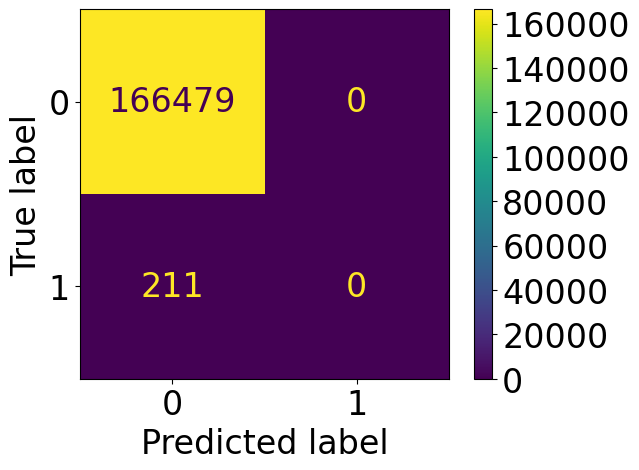

<Figure size 640x480 with 0 Axes>

In [90]:
from sklearn.metrics import jaccard_score
print(jaccard_score(predictions.A,y_test, average='samples', zero_division=True))
print(jaccard_score(y_test,predictions.A, average='macro',zero_division=True))
print(jaccard_score(y_test,predictions.A, average='weighted',zero_division=True))
print(jaccard_score(y_test,predictions.A, average='micro',zero_division=True))

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
print(multilabel_confusion_matrix(y_test, predictions.A))


matrices = multilabel_confusion_matrix(y_test, predictions)

print(type(y_test))

cm = confusion_matrix(y_test.A.ravel(), predictions.A.ravel())
plt.rcParams.update({'font.size': 24})
# Create a ConfusionMatrixDisplay object
#cmd = ConfusionMatrixDisplay(cm, display_labels=[f"Class {i}" for i in range(2)])
cmd = ConfusionMatrixDisplay.from_predictions(y_test.A.ravel(), predictions.A.ravel(),values_format='')
# Display the confusion matrix
cmd.plot()
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/BR_kNN/CM_BR_kNN_" + split_factor_file_train + "_flattened.eps", transparent=True, format='png', bbox_inches='tight')
plt.rcParams.update({'font.size': 10})
plt.clf()




num_classes = len(matrices)
print(num_classes)
# Initialize an empty list to store the true positive row indices
tp_indices = []

# Iterate over each class
for i in range(num_classes):
    # Get the confusion matrix for the current class
    class_cm = matrices[i]
    #print(class_cm.shape)
    
    # Extract the true positive count from the confusion matrix
    tp = class_cm[1, 1]
    
    # If the true positive count is greater than 0, add the index to the list
    if tp > 0:
        tp_indices.append(i)


#rows que testaram true positive        
print(tp_indices)
proteins_confusion_matrix_flattened = []
if (len(tp_indices)>0):
    for i in tp_indices:
        print(df_train.columns[i])
        proteins_confusion_matrix_flattened.append(df_train.columns[i])
    pd.DataFrame(proteins_confusion_matrix_flattened).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/BR_kNN/true_positive_proteins__flattened_Age_BMI_" + split_factor_file_train + ".csv") 
 
#define rows to add
rows_to_append = pd.DataFrame([{'Model':'BR_kNN', 'Proportion':split_factor_file_train, 
                                'HL':hamming_loss(y_test, predictions),
                               'Prec':precision_recall_fscore_support(y_test, predictions, average='macro',zero_division=1)[0],
                               'Rec':precision_recall_fscore_support(y_test, predictions, average='macro',zero_division=1)[1],
                               'F1':precision_recall_fscore_support(y_test, predictions, average='macro',zero_division=1)[2],
                               'Jac':jaccard_score(y_test,predictions, average='macro',zero_division=True)}])
                           

#add row to empty DataFrame
df_model_scores = pd.concat([df_model_scores, rows_to_append])

df_model_scores.head()
        
    
row_to_append = pd.DataFrame([{'Model' : 'BRV kNN', 'Split' : split_factor_file_train, 'TP' : cm[1,1], 'Sorting' : 'BMI (given Age)'}])
df_TP_CM = pd.concat([df_TP_CM,row_to_append])

(211, 790)
(211, 790)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
M is  (790, 790)
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  0
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  1
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  2
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  34
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  35
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  36
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [

kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  74
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  75
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  76
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0

kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  115
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  116
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  117
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  154
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  155
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  156
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]

C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  194
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  195
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  0 , shape =  (790,)
i =  196
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0

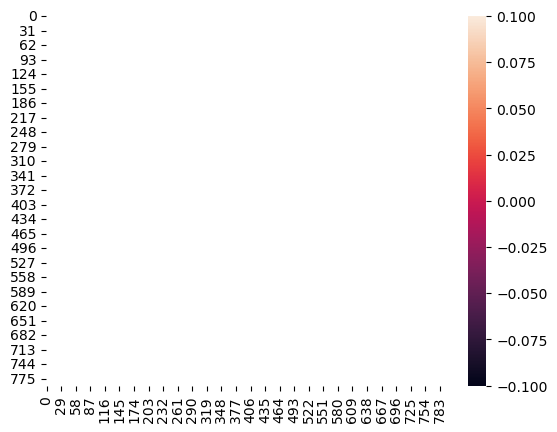

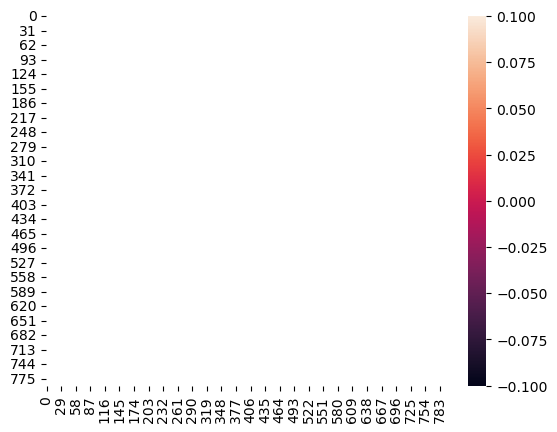

In [91]:
#y_test is already ndarray
Z = predictions.A
print(Z.shape)
Y = y_test.A
print(Y.shape)
M = confusion_matrix_article(Y,Z)
precision_M = precision_matrix(M)

ax = sns.heatmap(M, linewidth=0.5)
plt.show()

ax = sns.heatmap(precision_M, linewidth=0.5)
plt.show()

### Confusion Matrix Article

Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.

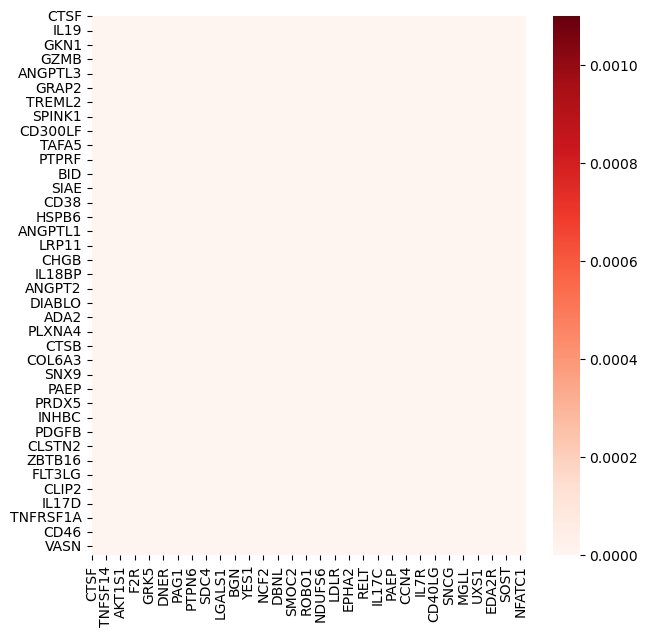

[]


<Figure size 640x480 with 0 Axes>

In [92]:
max_value = np.float64(0)
min_value = np.float64(0)


tp_indices_article = []


for row in range(0,len(precision_M)):
    #max_value = np.float64(max(precision_M[row,:]))
    
    
    #if(max(precision_M[row,:])>0):
    #    print(max(precision_M[row,:]>0))
    #else:
    #    print(max(precision_M[row,:]>0))
    if(max(precision_M[row,:])>0):
        tp_indices_article.append(row)
     
    if(max(precision_M[row,:])>max_value):
        if(max(precision_M[row,:])<1):
            max_value = np.float64(max(precision_M[row,:]))
            
    
    if(min(precision_M[row,:])>min_value):
        min_value = np.float64(min(precision_M[row,:]))
        
    print("Max value: ", max_value, ". Min value: ",min_value) 
    

if(max_value==0):
    max_value = np.float64(0.001)
    
    
plt.figure(figsize = (7,7))   
df_precision_M = pd.DataFrame(precision_M, columns = df_train.iloc[:,:-2].columns, index = df_train.iloc[:,:-2].columns )
df_precision_M
ax = sns.heatmap(df_precision_M,vmin=min_value, vmax=max_value*1.1, cmap="Reds")
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/BR_kNN/CM_BR_kNN_" + split_factor_file_train + "_article.eps", transparent=True, format='png')

plt.show()
plt.clf()

#rows que testaram true positive    
proteins_confusion_matrix_article = []
print(tp_indices_article)
if (len(tp_indices_article)>0):
    for i in tp_indices_article:
        proteins_confusion_matrix_article.append(df_train.columns[i])
        print(df_train.columns[i])
    proteins_confusion_matrix_article.append(max_value)
    pd.DataFrame(proteins_confusion_matrix_article).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/BR_kNN/true_positive_proteins_Age_BMI_" + split_factor_file_train + ".csv") 

In [93]:
print(np.__version__)

1.23.5


### RakelD

In [94]:
%%time
from sklearn.naive_bayes import GaussianNB
from skmultilearn.ensemble import RakelD

classifier = RakelD(
    base_classifier=GaussianNB(),
    base_classifier_require_dense=[True, True],
)



classifier.fit(X_train,y_train)
predictions = classifier.predict(X_test)
print(hamming_loss(y_test,predictions))

/Users/marcelo_palermo/anaconda3/envs/tese/lib/python3.10/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)


0.20560321554982303
CPU times: user 2.32 s, sys: 45 ms, total: 2.36 s
Wall time: 2.74 s


In [95]:
from sklearn.metrics import classification_report

labels = df_train.columns
len(labels)
label_names = labels[:-2]

print(classification_report(y_test, predictions,target_names=label_names,zero_division=1))
#print(classification_report(y_test, previsto,target_names=label_names,zero_division=1))

from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test, predictions, average='macro',zero_division=1))

                precision    recall  f1-score   support

          CTSF       1.00      1.00      1.00         0
         CRHBP       0.01      1.00      0.01         1
          WIF1       0.00      1.00      0.00         0
         EGFL7       0.01      1.00      0.01         1
          CLPS       1.00      1.00      1.00         0
          GGT1       1.00      0.00      0.00         1
       CEACAM1       1.00      0.00      0.00         1
        EFEMP1       0.00      1.00      0.00         0
         CCL17       1.00      1.00      1.00         0
          ABL1       1.00      1.00      1.00         0
        SPINK4       1.00      1.00      1.00         0
         NTRK3       1.00      1.00      1.00         0
      SERPINB6       1.00      1.00      1.00         0
          CFC1       1.00      1.00      1.00         0
         IGSF8       1.00      1.00      1.00         0
          NRP1       1.00      0.00      0.00         1
         STK11       1.00      1.00      1.00  

0.001068405336547681
0.49265693619219836
0.0009430312409323919
0.0011366617119874093
[[[211   0]
  [  0   0]]

 [[ 15 195]
  [  0   1]]

 [[ 15 196]
  [  0   0]]

 ...

 [[210   0]
  [  1   0]]

 [[210   0]
  [  1   0]]

 [[210   0]
  [  1   0]]]
<class 'scipy.sparse._csr.csr_matrix'>
790
[1, 3, 22, 54, 60, 154, 174, 198, 214, 228, 260, 299, 312, 327, 334, 357, 369, 391, 394, 403, 438, 451, 474, 503, 523, 527, 530, 543, 546, 547, 578, 597, 605, 700, 709, 714, 741, 742, 757]
CRHBP
EGFL7
DNMBP
RGMA
IGF2R
SERPINA12
RNASE3
HS6ST1
ANXA11
SEMA4D
BGN
CHRDL1
NCF2
BMP6
DCN
CHGB
ACTN4
MPO
TXNDC5
CCL15
KIR2DL3
DPT
MSR1
FGF5
FAM3B
ADAM22
CANT1
EPHB6
PAEP
DDX58
SLIT2
CDCP1
PLIN3
NELL2
GPNMB
IL17D
DBI
DSG2
ADAM23


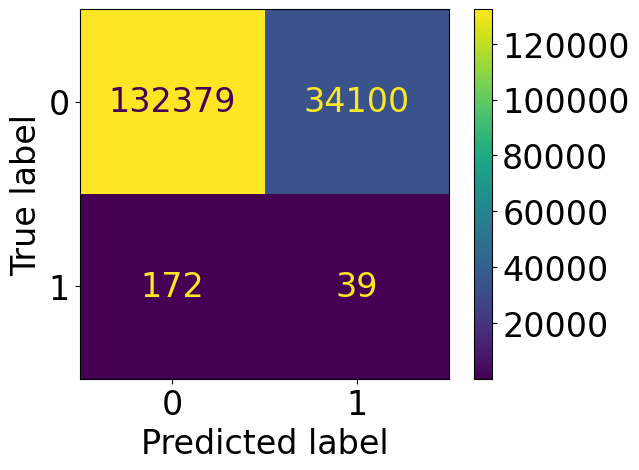

<Figure size 640x480 with 0 Axes>

In [96]:
from sklearn.metrics import jaccard_score
print(jaccard_score(predictions.A,y_test, average='samples', zero_division=True))
print(jaccard_score(y_test,predictions.A, average='macro',zero_division=True))
print(jaccard_score(y_test,predictions.A, average='weighted',zero_division=True))
print(jaccard_score(y_test,predictions.A, average='micro',zero_division=True))

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
print(multilabel_confusion_matrix(y_test, predictions.A))


matrices = multilabel_confusion_matrix(y_test, predictions)

print(type(y_test))

cm = confusion_matrix(y_test.A.ravel(), predictions.A.ravel())

plt.rcParams.update({'font.size': 24})
# Create a ConfusionMatrixDisplay object
#cmd = ConfusionMatrixDisplay(cm, display_labels=[f"Class {i}" for i in range(2)])
cmd = ConfusionMatrixDisplay.from_predictions(y_test.A.ravel(), predictions.A.ravel(),values_format='')
# Display the confusion matrix
cmd.plot()
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/RakelD/CM_RakelD_" + split_factor_file_train + "_flattened.eps", transparent=True, format='png', bbox_inches='tight')
plt.rcParams.update({'font.size': 10})
plt.clf()



num_classes = len(matrices)
print(num_classes)
# Initialize an empty list to store the true positive row indices
tp_indices = []

# Iterate over each class
for i in range(num_classes):
    # Get the confusion matrix for the current class
    class_cm = matrices[i]
    #print(class_cm.shape)
    
    # Extract the true positive count from the confusion matrix
    tp = class_cm[1, 1]
    
    # If the true positive count is greater than 0, add the index to the list
    if tp > 0:
        tp_indices.append(i)


#rows que testaram true positive        
print(tp_indices)
proteins_confusion_matrix_flattened = []
if (len(tp_indices)>0):
    for i in tp_indices:
        print(df_train.columns[i])
        proteins_confusion_matrix_flattened.append(df_train.columns[i])
    pd.DataFrame(proteins_confusion_matrix_flattened).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/RakelD/true_positive_proteins__flattened_Age_BMI_" + split_factor_file_train + ".csv") 
 

#define rows to add
rows_to_append = pd.DataFrame([{'Model':'RakelD', 'Proportion':split_factor_file_train, 
                                'HL':hamming_loss(y_test, predictions),
                               'Prec':precision_recall_fscore_support(y_test, predictions, average='macro',zero_division=1)[0],
                               'Rec':precision_recall_fscore_support(y_test, predictions, average='macro',zero_division=1)[1],
                               'F1':precision_recall_fscore_support(y_test, predictions, average='macro',zero_division=1)[2],
                               'Jac':jaccard_score(y_test,predictions, average='macro',zero_division=True)}])
                           

#add row to empty DataFrame
df_model_scores = pd.concat([df_model_scores, rows_to_append])

df_model_scores.head()

row_to_append = pd.DataFrame([{'Model' : 'RKD', 'Split' : split_factor_file_train, 'TP' : cm[1,1], 'Sorting' : 'BMI (given Age)'}])
df_TP_CM = pd.concat([df_TP_CM,row_to_append])

(211, 790)
(211, 790)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
M is  (790, 790)
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  15 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  15 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  15 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  15 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  15 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  0 , shape =  (790,)
|Zi\Yi| =  15 , shape =  (790,)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  15 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  15 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  0 , shape =  (790,)
|Zi\Yi| =  15 , shape =  (790,)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  0 , shape =  (790,)
|Zi\Yi| =  15 , shape =  (790,)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  15 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  15 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  0 , shape =  (790,)
|Zi\Yi| =  15 , shape =  (790,)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.00578035 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
|Yi\Zi| =  0 , shape =  (790,)
|Zi\Yi| =  15 , shape =  (790,)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (790,)
|Zi\Yi| =  15 , shape =  (790,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.

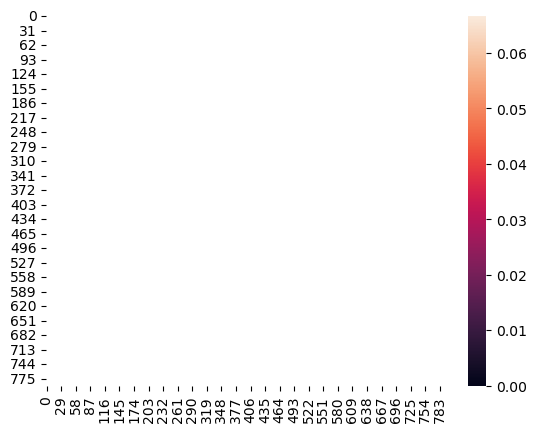

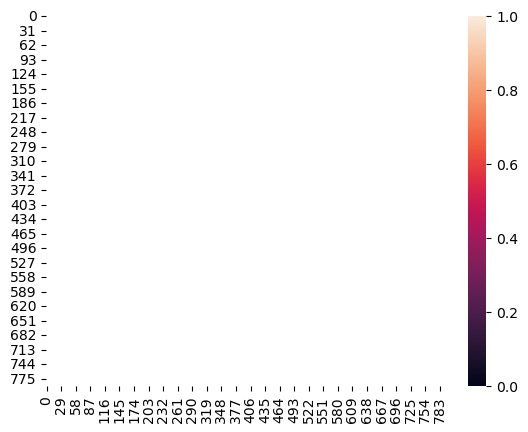

In [97]:
#y_test is already ndarray
Z = predictions.A
print(Z.shape)
Y = y_test.A
print(Y.shape)
M = confusion_matrix_article(Y,Z)
precision_M = precision_matrix(M)

ax = sns.heatmap(M, linewidth=0.5)
plt.show()

ax = sns.heatmap(precision_M, linewidth=0.5)
plt.show()

### Confusion Matrix Article

Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.005701855574964579 . Min value:  0.0
Max value:  0.005701855574964579 . Min value:  0.0
Max value:  0.005701855574964579 . Min value:  0.0
Max value:  0.005701855574964579 . Min value:  0.0
Max value:  0.005701855574964579 . Min value:  0.0
Max value:  0.005701855574964579 . Min value:  0.0
Max value:  0.005701855574964579 . Min value:  0.0
Max value:  0.005701855574964579 . Min value:  0.0
Max value:  0.005701855574964579 . Min value:  0.0
Max value:  0.005701855574964579 . Min value:  0.0
Max value:  0.005701855574964579 . Min value:  0.0
Max value:  0.005701855574964579 . Min value:  0.0
Max value:  0.005701855574964579 . Min value:  0.0
Max value:  0.005701855574964579 . Min value:  0.0
Max value:  0.005701855574964579 . Min value:  0.0
Max value:  0.005701855574964579 . Min value:  0.0
Max value:  0.

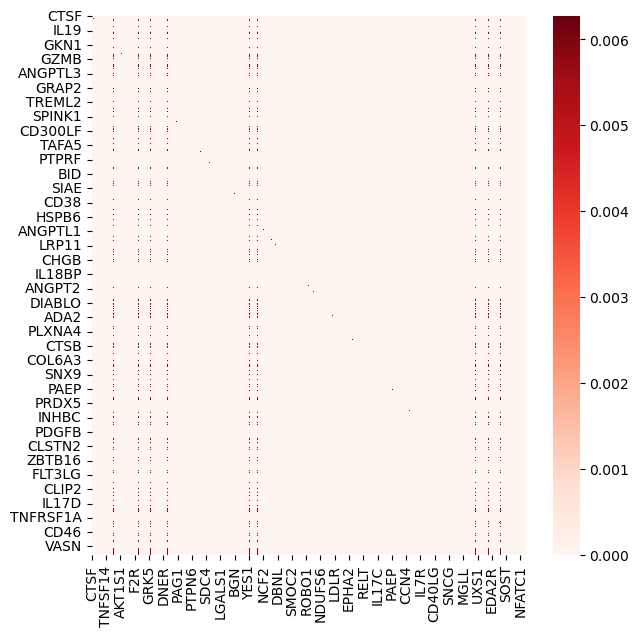

[1, 3, 5, 6, 15, 22, 24, 25, 32, 46, 54, 56, 57, 59, 60, 61, 62, 71, 72, 73, 74, 76, 84, 87, 105, 106, 110, 111, 124, 125, 135, 139, 147, 154, 161, 162, 164, 166, 169, 174, 179, 181, 186, 193, 195, 196, 197, 198, 209, 212, 214, 222, 223, 228, 242, 245, 248, 253, 260, 268, 269, 283, 284, 290, 298, 299, 300, 307, 312, 316, 319, 323, 327, 329, 334, 335, 338, 342, 345, 349, 356, 357, 359, 363, 366, 369, 373, 376, 391, 394, 397, 398, 403, 404, 415, 416, 417, 420, 421, 422, 425, 426, 428, 431, 432, 435, 437, 438, 440, 441, 451, 455, 457, 467, 468, 470, 474, 476, 479, 481, 484, 485, 494, 502, 503, 504, 508, 510, 512, 513, 517, 519, 523, 525, 527, 530, 532, 540, 542, 543, 546, 547, 548, 549, 559, 560, 562, 578, 581, 586, 588, 595, 597, 598, 599, 605, 615, 619, 620, 624, 625, 627, 632, 635, 643, 647, 651, 653, 659, 665, 666, 669, 675, 683, 687, 692, 697, 698, 700, 702, 709, 710, 714, 717, 721, 723, 724, 726, 740, 741, 742, 743, 748, 757, 758, 761, 763, 768, 769, 770, 779, 780, 781, 782, 783, 78

<Figure size 640x480 with 0 Axes>

In [98]:
max_value = np.float64(0)
min_value = np.float64(0)


tp_indices_article = []


for row in range(0,len(precision_M)):
    #max_value = np.float64(max(precision_M[row,:]))
    
    
    #if(max(precision_M[row,:])>0):
    #    print(max(precision_M[row,:]>0))
    #else:
    #    print(max(precision_M[row,:]>0))
    if(max(precision_M[row,:])>0):
        tp_indices_article.append(row)
     
    if(max(precision_M[row,:])>max_value):
        if(max(precision_M[row,:])<1):
            max_value = np.float64(max(precision_M[row,:]))
            
    
    if(min(precision_M[row,:])>min_value):
        min_value = np.float64(min(precision_M[row,:]))
        
    print("Max value: ", max_value, ". Min value: ",min_value) 
    

if(max_value==0):
    max_value = np.float64(0.001)
    
    
plt.figure(figsize = (7,7))   
df_precision_M = pd.DataFrame(precision_M, columns = df_train.iloc[:,:-2].columns, index = df_train.iloc[:,:-2].columns )
df_precision_M
ax = sns.heatmap(df_precision_M,vmin=min_value, vmax=max_value*1.1, cmap="Reds")
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/RakelD/CM_RakelD_" + split_factor_file_train + "_article.eps", transparent=True, format='png')

plt.show()
plt.clf()


#rows que testaram true positive    
proteins_confusion_matrix_article = []
print(tp_indices_article)
if (len(tp_indices_article)>0):
    for i in tp_indices_article:
        proteins_confusion_matrix_article.append(df_train.columns[i])
        print(df_train.columns[i])
    proteins_confusion_matrix_article.append(max_value)
    pd.DataFrame(proteins_confusion_matrix_article).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/RakelD/true_positive_proteins_Age_BMI_" + split_factor_file_train + ".csv") 

In [99]:
df_model_scores.to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/Scores_Age_BMI_" + split_factor_file_train + ".csv") 

In [100]:
df_TP_CM.to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/Age_BMI/ML Models/True_Positives_Age_BMI_" + split_factor_file_train + ".csv") 

In [101]:
#exit()